# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

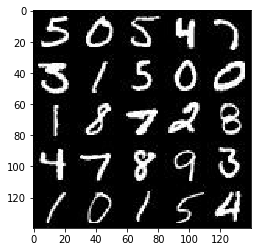

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

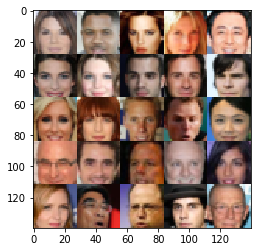

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [5]:
# Some fallbacks for old versions of tensorflow (1.3 on AWS)
try:
    leaky_relu = tf.nn.leaky_relu
except AttributeError:
    warnings.warn('Using fallback leaky_relu')
    def leaky_relu(inputs, alpha=0.2):
        return tf.maximum(inputs, inputs * alpha)
    

try:
    flatten = tf.layers.flatten
except AttributeError:
    warnings.warn('Using fallback flatten')
    import functools
    import operator
    
    def flatten(inputs):
        shape = inputs.get_shape()
        target_dim = functools.reduce(operator.mul, map(int, shape[1:]))
        return tf.reshape(inputs, [-1, target_dim])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: Using fallback leaky_relu
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: UserWarning: Using fallback flatten
  del sys.path[0]


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_inputs')
    random_inputs = tf.placeholder(tf.float32, shape=[None, z_dim])
    learning_rate = tf.placeholder(tf.float32)
    is_training = tf.placeholder(tf.bool)
    return real_inputs, random_inputs, learning_rate, is_training


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ValueError: too many values to unpack (expected 3)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
KERNEL_SIZE = 5
STRIDES = 2


def conv2d(inputs, filters, is_training, normalization=True, activation=True, kernel_size=KERNEL_SIZE):
    output = tf.layers.conv2d(
        inputs=inputs, filters=filters,
        kernel_size=kernel_size, strides=STRIDES, padding='same',
        use_bias=not normalization
    )
    if normalization:
        output = tf.layers.batch_normalization(output, training=is_training)
    if activation:
        output = leaky_relu(output)
    return output
    
    
def dense(inputs, units, is_training, normalization=True, activation=True):
    output = tf.layers.dense(
        inputs=inputs, units=units, use_bias=not normalization
    )
    if normalization:
        output = tf.layers.batch_normalization(output, training=is_training)
    if activation:
        output = leaky_relu(output)
    return output
    
    
def discriminator(images, reuse, is_training):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        output = images
        # Shape 28x28xchannels
        output = conv2d(output, 128, is_training, normalization=False)
        # Shape is 14x14x128
        output = conv2d(output, 256, is_training)
        # Shape 7x7x256
        output = conv2d(output, 512, is_training)
        # Shape 4x4x512
        print('discriminator', output.get_shape())
        output = flatten(output)
        # Shape 4*4*512 = 8K
        
        logits = dense(output, 1, is_training, normalization=False, activation=False)
        output = tf.nn.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

TypeError: discriminator() missing 2 required positional arguments: 'reuse' and 'is_training'

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def conv2d_transpose(inputs, filters, is_training, normalization=True, activation=True, kernel_size=KERNEL_SIZE):
    output = tf.layers.conv2d_transpose(
        inputs, filters=filters,
        kernel_size=kernel_size, strides=STRIDES, padding='same',
        use_bias=not normalization
    )
    if normalization:
        output = tf.layers.batch_normalization(output, training=is_training)
    if activation:
        output = leaky_relu(output)
    return output


def generator(z, out_channel_dim, is_training, reuse=False):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=reuse):
        output = dense(z, 4 * 4 * 512, is_training, normalization=False)
        output = tf.reshape(output, [-1, 4, 4, 512])
        # Shape is 4x4x512
        output = conv2d_transpose(output, 256, is_training)
        # Shape is 8x8x256
        output = conv2d_transpose(output, 128, is_training)
        # Shape ix 16x16x128
        output = conv2d_transpose(
            output, out_channel_dim, is_training,
            normalization=False, activation=False
        )
        # Shape is 32x32xout_channel_dim
        output = tf.tanh(output)
        output = tf.image.crop_to_bounding_box(output, 2, 2, 28, 28)
        # Shape is 28x28xout_channel_dim
        print('generator out', output.get_shape())
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

TypeError: generator() missing 1 required positional argument: 'is_training'

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, is_training):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_model = generator(input_z, out_channel_dim, is_training=is_training, reuse=False)
    discriminator_model_real, discriminator_logits_real = discriminator(
        input_real, reuse=False, is_training=is_training
    )
    discriminator_model_fake, discriminator_logits_fake = discriminator(
        generator_model, reuse=True, is_training=is_training
    )
    discriminator_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_real, labels=tf.ones_like(discriminator_logits_real)
    ))
    discriminator_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_logits_fake)
    ))
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_logits_fake)
    ))
    discriminator_loss = discriminator_real_loss + discriminator_fake_loss
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

TypeError: model_loss() missing 1 required positional argument: 'is_training'

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_vars = tf.trainable_variables()
    discriminator_variables = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_variables = [var for var in trainable_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1
        ).minimize(
            d_loss, var_list=discriminator_variables
        )
        generator_optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1
        ).minimize(
            g_loss, var_list=generator_variables
        )
    
    return discriminator_optimizer, generator_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, is_training):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_training, reuse=True),
        feed_dict={input_z: example_z, is_training: False}
    )

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
PRINT_EVERY = 5
VIEW_EVERY = PRINT_EVERY * 3

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    number_of_examples, *_, out_channel_dim = data_shape
    real_images, z, learning_rate_tensor, is_training = model_inputs(*data_shape[1:], z_dim)
    batches_per_epoch = int(number_of_examples / batch_size)
    
    discriminator_loss, generator_loss = model_loss(real_images, z, out_channel_dim, is_training=is_training)
    discriminator_opt, generator_opt = model_opt(discriminator_loss, generator_loss, learning_rate_tensor, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        step = 0
        view_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                feed_dict = {
                    real_images: batch_images,
                    z: batch_z,
                    learning_rate_tensor: learning_rate,
                    is_training: True
                }
                sess.run([discriminator_opt, generator_opt], feed_dict=feed_dict)
                if step % PRINT_EVERY == 0:
                    train_loss_discriminator = discriminator_loss.eval(feed_dict)
                    train_loss_generator = generator_loss.eval(feed_dict)
                    print(
                        'Epoch {epoch_i}/{epoch_count} '
                        'Step {step}/{steps}: '
                        'Discriminator Loss: {train_loss_discriminator:.4f}. '
                        'Generator Loss: {train_loss_generator:.4f}'.format(
                            epoch_i=epoch_i + 1,
                            epoch_count=epoch_count,
                            step=step,
                            steps=batches_per_epoch * epoch_count,
                            train_loss_generator=train_loss_generator,
                            train_loss_discriminator=train_loss_discriminator
                        )
                    )
                if step % VIEW_EVERY == 0:
                    show_generator_output(sess, 16, z, out_channel_dim, data_image_mode, is_training)
                step += 1
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

generator out (?, 28, 28, 1)
discriminator (?, 4, 4, 512)
discriminator (?, 4, 4, 512)
Epoch 1/2 Step 0/936: Discriminator Loss: 1.2737. Generator Loss: 0.6159
generator out (?, 28, 28, 1)


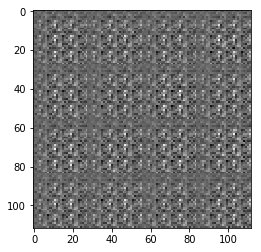

Epoch 1/2 Step 5/936: Discriminator Loss: 0.0192. Generator Loss: 32.7675
Epoch 1/2 Step 10/936: Discriminator Loss: 0.0000. Generator Loss: 37.4634
Epoch 1/2 Step 15/936: Discriminator Loss: 0.0000. Generator Loss: 28.4622
generator out (?, 28, 28, 1)


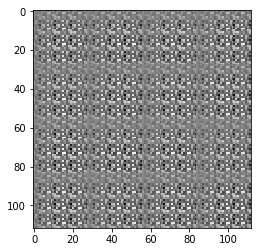

Epoch 1/2 Step 20/936: Discriminator Loss: 0.0326. Generator Loss: 32.8423
Epoch 1/2 Step 25/936: Discriminator Loss: 12.1131. Generator Loss: 40.7485
Epoch 1/2 Step 30/936: Discriminator Loss: 0.0343. Generator Loss: 14.4393
generator out (?, 28, 28, 1)


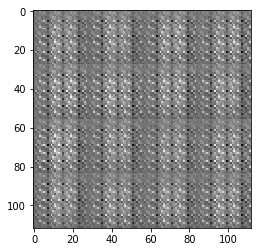

Epoch 1/2 Step 35/936: Discriminator Loss: 1.0818. Generator Loss: 2.4028
Epoch 1/2 Step 40/936: Discriminator Loss: 1.2074. Generator Loss: 22.7800
Epoch 1/2 Step 45/936: Discriminator Loss: 1.3352. Generator Loss: 1.1654
generator out (?, 28, 28, 1)


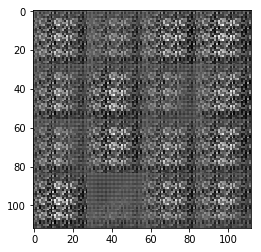

Epoch 1/2 Step 50/936: Discriminator Loss: 1.2694. Generator Loss: 14.3704
Epoch 1/2 Step 55/936: Discriminator Loss: 0.8421. Generator Loss: 1.6927
Epoch 1/2 Step 60/936: Discriminator Loss: 3.0368. Generator Loss: 4.0446
generator out (?, 28, 28, 1)


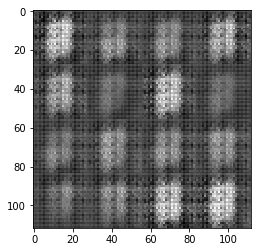

Epoch 1/2 Step 65/936: Discriminator Loss: 0.3749. Generator Loss: 1.9579
Epoch 1/2 Step 70/936: Discriminator Loss: 0.6822. Generator Loss: 3.7793
Epoch 1/2 Step 75/936: Discriminator Loss: 0.6232. Generator Loss: 1.3332
generator out (?, 28, 28, 1)


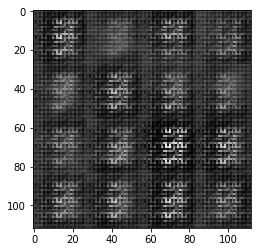

Epoch 1/2 Step 80/936: Discriminator Loss: 3.5327. Generator Loss: 0.1016
Epoch 1/2 Step 85/936: Discriminator Loss: 0.3575. Generator Loss: 2.1634
Epoch 1/2 Step 90/936: Discriminator Loss: 0.2527. Generator Loss: 2.4224
generator out (?, 28, 28, 1)


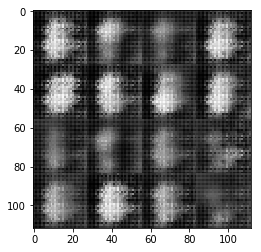

Epoch 1/2 Step 95/936: Discriminator Loss: 0.6979. Generator Loss: 1.5796
Epoch 1/2 Step 100/936: Discriminator Loss: 0.3512. Generator Loss: 3.4005
Epoch 1/2 Step 105/936: Discriminator Loss: 0.2355. Generator Loss: 3.6487
generator out (?, 28, 28, 1)


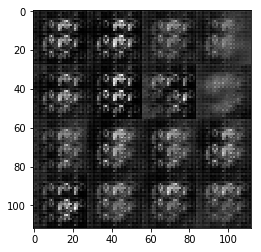

Epoch 1/2 Step 110/936: Discriminator Loss: 0.2918. Generator Loss: 2.9583
Epoch 1/2 Step 115/936: Discriminator Loss: 0.0921. Generator Loss: 3.3766
Epoch 1/2 Step 120/936: Discriminator Loss: 0.3213. Generator Loss: 2.5845
generator out (?, 28, 28, 1)


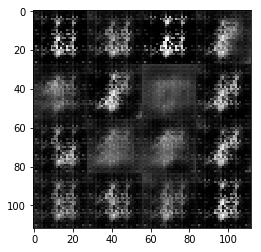

Epoch 1/2 Step 125/936: Discriminator Loss: 0.6353. Generator Loss: 0.9462
Epoch 1/2 Step 130/936: Discriminator Loss: 0.1304. Generator Loss: 2.9218
Epoch 1/2 Step 135/936: Discriminator Loss: 0.1577. Generator Loss: 3.6501
generator out (?, 28, 28, 1)


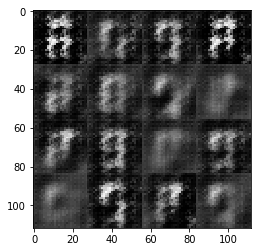

Epoch 1/2 Step 140/936: Discriminator Loss: 0.1297. Generator Loss: 3.7857
Epoch 1/2 Step 145/936: Discriminator Loss: 3.3283. Generator Loss: 15.6458
Epoch 1/2 Step 150/936: Discriminator Loss: 0.6330. Generator Loss: 2.1562
generator out (?, 28, 28, 1)


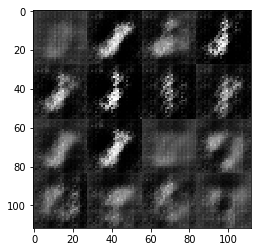

Epoch 1/2 Step 155/936: Discriminator Loss: 0.4349. Generator Loss: 2.0992
Epoch 1/2 Step 160/936: Discriminator Loss: 0.1224. Generator Loss: 3.5960
Epoch 1/2 Step 165/936: Discriminator Loss: 0.1572. Generator Loss: 2.7476
generator out (?, 28, 28, 1)


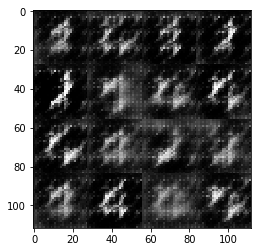

Epoch 1/2 Step 170/936: Discriminator Loss: 0.4268. Generator Loss: 6.7564
Epoch 1/2 Step 175/936: Discriminator Loss: 0.0999. Generator Loss: 3.4235
Epoch 1/2 Step 180/936: Discriminator Loss: 0.1619. Generator Loss: 2.4265
generator out (?, 28, 28, 1)


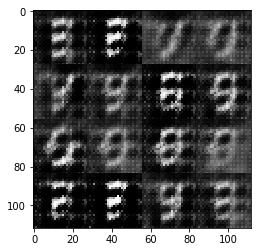

Epoch 1/2 Step 185/936: Discriminator Loss: 0.1040. Generator Loss: 3.1880
Epoch 1/2 Step 190/936: Discriminator Loss: 0.0726. Generator Loss: 4.4146
Epoch 1/2 Step 195/936: Discriminator Loss: 0.3489. Generator Loss: 1.5638
generator out (?, 28, 28, 1)


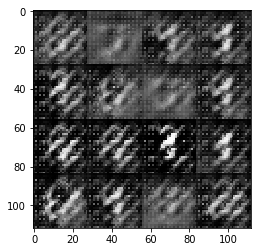

Epoch 1/2 Step 200/936: Discriminator Loss: 0.1755. Generator Loss: 12.8881
Epoch 1/2 Step 205/936: Discriminator Loss: 0.1930. Generator Loss: 3.7896
Epoch 1/2 Step 210/936: Discriminator Loss: 0.2769. Generator Loss: 5.1038
generator out (?, 28, 28, 1)


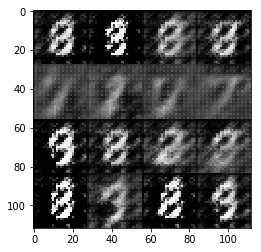

Epoch 1/2 Step 215/936: Discriminator Loss: 0.3171. Generator Loss: 2.6472
Epoch 1/2 Step 220/936: Discriminator Loss: 0.0866. Generator Loss: 4.0909
Epoch 1/2 Step 225/936: Discriminator Loss: 0.0647. Generator Loss: 3.6920
generator out (?, 28, 28, 1)


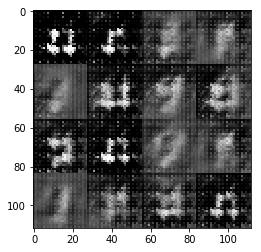

Epoch 1/2 Step 230/936: Discriminator Loss: 0.1340. Generator Loss: 2.9286
Epoch 1/2 Step 235/936: Discriminator Loss: 0.2266. Generator Loss: 2.0117
Epoch 1/2 Step 240/936: Discriminator Loss: 0.0437. Generator Loss: 6.4149
generator out (?, 28, 28, 1)


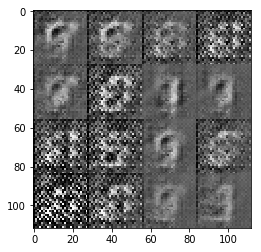

Epoch 1/2 Step 245/936: Discriminator Loss: 0.1907. Generator Loss: 5.7196
Epoch 1/2 Step 250/936: Discriminator Loss: 0.0733. Generator Loss: 3.9788
Epoch 1/2 Step 255/936: Discriminator Loss: 0.4686. Generator Loss: 2.3164
generator out (?, 28, 28, 1)


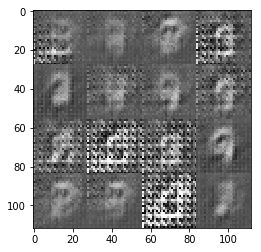

Epoch 1/2 Step 260/936: Discriminator Loss: 0.0531. Generator Loss: 4.0888
Epoch 1/2 Step 265/936: Discriminator Loss: 0.1516. Generator Loss: 6.8925
Epoch 1/2 Step 270/936: Discriminator Loss: 0.0125. Generator Loss: 9.8774
generator out (?, 28, 28, 1)


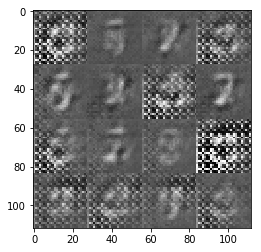

Epoch 1/2 Step 275/936: Discriminator Loss: 0.1847. Generator Loss: 3.2551
Epoch 1/2 Step 280/936: Discriminator Loss: 0.1556. Generator Loss: 8.9087
Epoch 1/2 Step 285/936: Discriminator Loss: 2.1233. Generator Loss: 0.2416
generator out (?, 28, 28, 1)


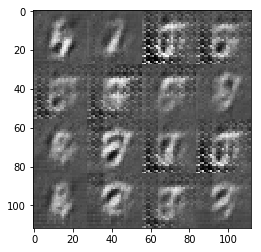

Epoch 1/2 Step 290/936: Discriminator Loss: 0.1764. Generator Loss: 4.3960
Epoch 1/2 Step 295/936: Discriminator Loss: 0.5648. Generator Loss: 1.6289
Epoch 1/2 Step 300/936: Discriminator Loss: 0.5715. Generator Loss: 1.2811
generator out (?, 28, 28, 1)


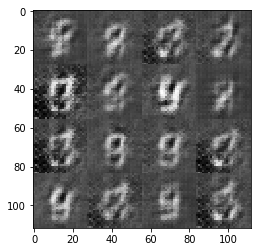

Epoch 1/2 Step 305/936: Discriminator Loss: 0.0776. Generator Loss: 3.8194
Epoch 1/2 Step 310/936: Discriminator Loss: 0.1680. Generator Loss: 2.7228
Epoch 1/2 Step 315/936: Discriminator Loss: 0.5095. Generator Loss: 1.9672
generator out (?, 28, 28, 1)


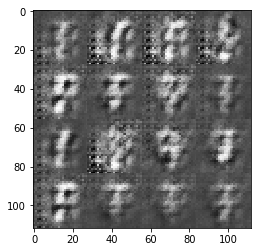

Epoch 1/2 Step 320/936: Discriminator Loss: 0.1741. Generator Loss: 2.8126
Epoch 1/2 Step 325/936: Discriminator Loss: 0.1501. Generator Loss: 2.5615
Epoch 1/2 Step 330/936: Discriminator Loss: 0.0851. Generator Loss: 4.4770
generator out (?, 28, 28, 1)


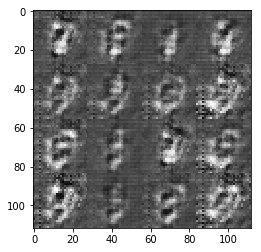

Epoch 1/2 Step 335/936: Discriminator Loss: 0.0538. Generator Loss: 5.2503
Epoch 1/2 Step 340/936: Discriminator Loss: 1.6023. Generator Loss: 0.7830
Epoch 1/2 Step 345/936: Discriminator Loss: 0.4901. Generator Loss: 6.1602
generator out (?, 28, 28, 1)


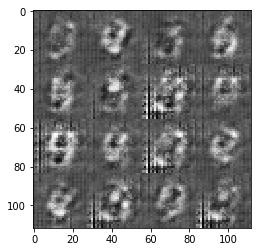

Epoch 1/2 Step 350/936: Discriminator Loss: 0.6450. Generator Loss: 2.4131
Epoch 1/2 Step 355/936: Discriminator Loss: 0.4890. Generator Loss: 1.4805
Epoch 1/2 Step 360/936: Discriminator Loss: 4.1268. Generator Loss: 11.0385
generator out (?, 28, 28, 1)


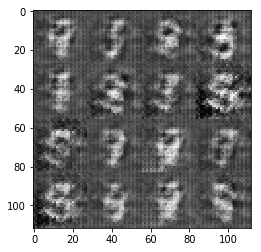

Epoch 1/2 Step 365/936: Discriminator Loss: 0.3201. Generator Loss: 2.0106
Epoch 1/2 Step 370/936: Discriminator Loss: 0.2814. Generator Loss: 2.7941
Epoch 1/2 Step 375/936: Discriminator Loss: 0.0814. Generator Loss: 4.1587
generator out (?, 28, 28, 1)


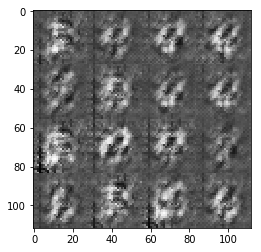

Epoch 1/2 Step 380/936: Discriminator Loss: 0.3064. Generator Loss: 2.1274
Epoch 1/2 Step 385/936: Discriminator Loss: 0.0397. Generator Loss: 7.9613
Epoch 1/2 Step 390/936: Discriminator Loss: 0.0336. Generator Loss: 6.0177
generator out (?, 28, 28, 1)


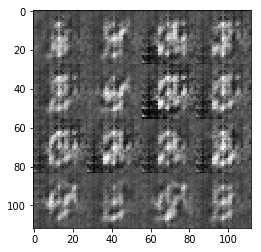

Epoch 1/2 Step 395/936: Discriminator Loss: 1.3368. Generator Loss: 0.4439
Epoch 1/2 Step 400/936: Discriminator Loss: 0.2352. Generator Loss: 5.9461
Epoch 1/2 Step 405/936: Discriminator Loss: 0.4159. Generator Loss: 1.5951
generator out (?, 28, 28, 1)


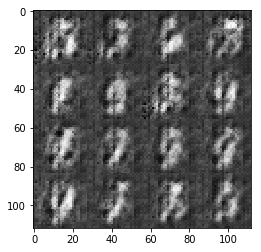

Epoch 1/2 Step 410/936: Discriminator Loss: 0.1497. Generator Loss: 8.7458
Epoch 1/2 Step 415/936: Discriminator Loss: 0.1983. Generator Loss: 2.4568
Epoch 1/2 Step 420/936: Discriminator Loss: 0.1457. Generator Loss: 2.6565
generator out (?, 28, 28, 1)


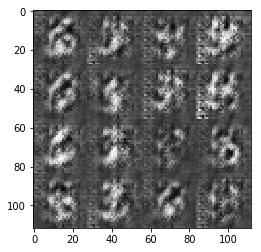

Epoch 1/2 Step 425/936: Discriminator Loss: 0.2091. Generator Loss: 7.9532
Epoch 1/2 Step 430/936: Discriminator Loss: 0.0298. Generator Loss: 4.6803
Epoch 1/2 Step 435/936: Discriminator Loss: 1.1816. Generator Loss: 11.8703
generator out (?, 28, 28, 1)


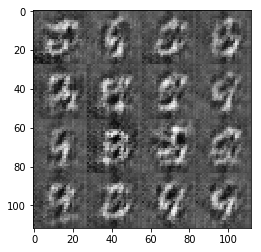

Epoch 1/2 Step 440/936: Discriminator Loss: 0.8223. Generator Loss: 1.5059
Epoch 1/2 Step 445/936: Discriminator Loss: 0.3094. Generator Loss: 3.2383
Epoch 1/2 Step 450/936: Discriminator Loss: 0.0693. Generator Loss: 6.7424
generator out (?, 28, 28, 1)


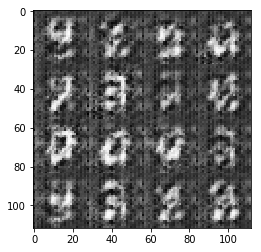

Epoch 1/2 Step 455/936: Discriminator Loss: 1.9311. Generator Loss: 10.0934
Epoch 1/2 Step 460/936: Discriminator Loss: 1.2445. Generator Loss: 0.4632
Epoch 1/2 Step 465/936: Discriminator Loss: 1.3507. Generator Loss: 3.0023
generator out (?, 28, 28, 1)


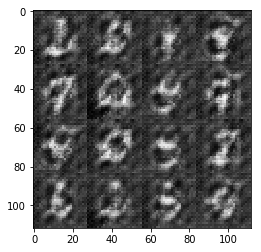

Epoch 2/2 Step 470/936: Discriminator Loss: 0.1996. Generator Loss: 4.2929
Epoch 2/2 Step 475/936: Discriminator Loss: 0.3740. Generator Loss: 2.0765
Epoch 2/2 Step 480/936: Discriminator Loss: 0.3109. Generator Loss: 1.9555
generator out (?, 28, 28, 1)


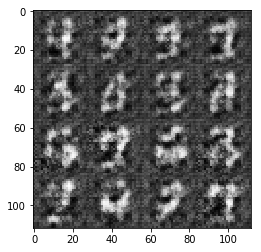

Epoch 2/2 Step 485/936: Discriminator Loss: 0.8830. Generator Loss: 1.0201
Epoch 2/2 Step 490/936: Discriminator Loss: 0.2966. Generator Loss: 2.0641
Epoch 2/2 Step 495/936: Discriminator Loss: 0.2936. Generator Loss: 2.1677
generator out (?, 28, 28, 1)


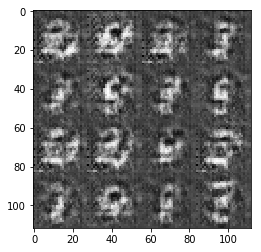

Epoch 2/2 Step 500/936: Discriminator Loss: 0.4612. Generator Loss: 1.7648
Epoch 2/2 Step 505/936: Discriminator Loss: 0.5370. Generator Loss: 1.3755
Epoch 2/2 Step 510/936: Discriminator Loss: 0.1350. Generator Loss: 3.3138
generator out (?, 28, 28, 1)


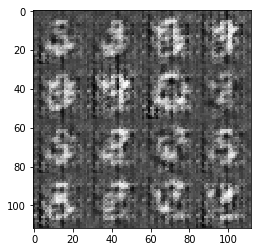

Epoch 2/2 Step 515/936: Discriminator Loss: 0.2474. Generator Loss: 2.3459
Epoch 2/2 Step 520/936: Discriminator Loss: 0.2287. Generator Loss: 3.3445
Epoch 2/2 Step 525/936: Discriminator Loss: 0.4578. Generator Loss: 1.3583
generator out (?, 28, 28, 1)


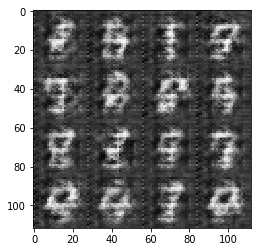

Epoch 2/2 Step 530/936: Discriminator Loss: 1.2077. Generator Loss: 0.5250
Epoch 2/2 Step 535/936: Discriminator Loss: 0.6224. Generator Loss: 1.1493
Epoch 2/2 Step 540/936: Discriminator Loss: 0.4527. Generator Loss: 1.5402
generator out (?, 28, 28, 1)


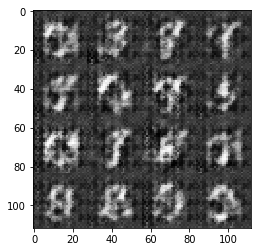

Epoch 2/2 Step 545/936: Discriminator Loss: 0.3121. Generator Loss: 1.8937
Epoch 2/2 Step 550/936: Discriminator Loss: 0.3619. Generator Loss: 1.8824
Epoch 2/2 Step 555/936: Discriminator Loss: 1.3163. Generator Loss: 13.3300
generator out (?, 28, 28, 1)


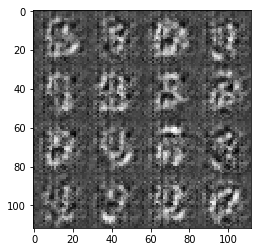

Epoch 2/2 Step 560/936: Discriminator Loss: 0.3348. Generator Loss: 2.1918
Epoch 2/2 Step 565/936: Discriminator Loss: 0.4811. Generator Loss: 1.4253
Epoch 2/2 Step 570/936: Discriminator Loss: 0.1533. Generator Loss: 2.5079
generator out (?, 28, 28, 1)


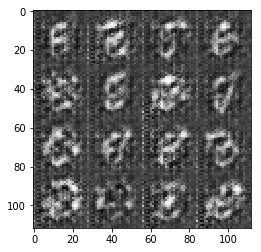

Epoch 2/2 Step 575/936: Discriminator Loss: 0.6591. Generator Loss: 7.7127
Epoch 2/2 Step 580/936: Discriminator Loss: 0.0483. Generator Loss: 4.0422
Epoch 2/2 Step 585/936: Discriminator Loss: 0.2899. Generator Loss: 2.0270
generator out (?, 28, 28, 1)


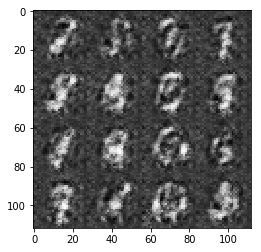

Epoch 2/2 Step 590/936: Discriminator Loss: 0.1142. Generator Loss: 3.3472
Epoch 2/2 Step 595/936: Discriminator Loss: 0.0522. Generator Loss: 3.9361
Epoch 2/2 Step 600/936: Discriminator Loss: 0.0913. Generator Loss: 4.1753
generator out (?, 28, 28, 1)


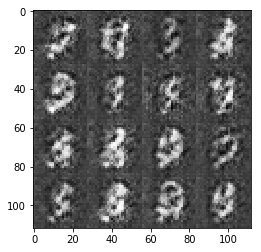

Epoch 2/2 Step 605/936: Discriminator Loss: 0.0825. Generator Loss: 4.0126
Epoch 2/2 Step 610/936: Discriminator Loss: 0.1616. Generator Loss: 2.3071
Epoch 2/2 Step 615/936: Discriminator Loss: 0.1064. Generator Loss: 2.9243
generator out (?, 28, 28, 1)


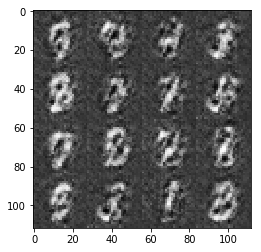

Epoch 2/2 Step 620/936: Discriminator Loss: 0.0405. Generator Loss: 6.1445
Epoch 2/2 Step 625/936: Discriminator Loss: 0.0299. Generator Loss: 5.3746
Epoch 2/2 Step 630/936: Discriminator Loss: 3.7575. Generator Loss: 0.0353
generator out (?, 28, 28, 1)


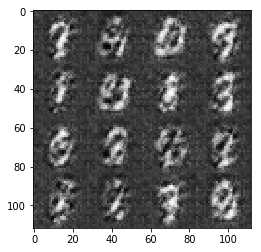

Epoch 2/2 Step 635/936: Discriminator Loss: 0.2547. Generator Loss: 3.8823
Epoch 2/2 Step 640/936: Discriminator Loss: 0.5969. Generator Loss: 1.6903
Epoch 2/2 Step 645/936: Discriminator Loss: 0.2904. Generator Loss: 2.0491
generator out (?, 28, 28, 1)


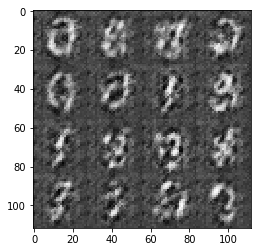

Epoch 2/2 Step 650/936: Discriminator Loss: 0.4820. Generator Loss: 1.4601
Epoch 2/2 Step 655/936: Discriminator Loss: 0.1117. Generator Loss: 2.7391
Epoch 2/2 Step 660/936: Discriminator Loss: 0.0539. Generator Loss: 4.0593
generator out (?, 28, 28, 1)


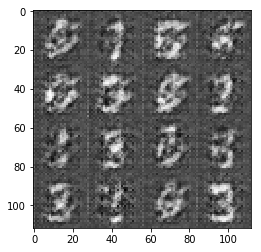

Epoch 2/2 Step 665/936: Discriminator Loss: 0.1094. Generator Loss: 3.0733
Epoch 2/2 Step 670/936: Discriminator Loss: 0.5809. Generator Loss: 1.0156
Epoch 2/2 Step 675/936: Discriminator Loss: 0.9530. Generator Loss: 11.3101
generator out (?, 28, 28, 1)


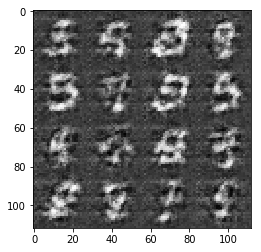

Epoch 2/2 Step 680/936: Discriminator Loss: 0.6075. Generator Loss: 1.3080
Epoch 2/2 Step 685/936: Discriminator Loss: 0.4084. Generator Loss: 1.5540
Epoch 2/2 Step 690/936: Discriminator Loss: 0.2620. Generator Loss: 2.0831
generator out (?, 28, 28, 1)


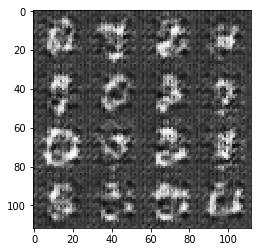

Epoch 2/2 Step 695/936: Discriminator Loss: 0.2484. Generator Loss: 2.1748
Epoch 2/2 Step 700/936: Discriminator Loss: 0.1405. Generator Loss: 3.0694
Epoch 2/2 Step 705/936: Discriminator Loss: 0.4068. Generator Loss: 1.9303
generator out (?, 28, 28, 1)


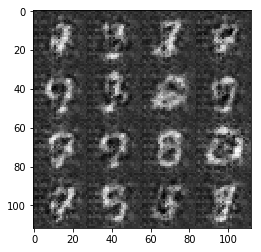

Epoch 2/2 Step 710/936: Discriminator Loss: 0.1718. Generator Loss: 2.9192
Epoch 2/2 Step 715/936: Discriminator Loss: 0.2534. Generator Loss: 1.8622
Epoch 2/2 Step 720/936: Discriminator Loss: 0.1200. Generator Loss: 3.0319
generator out (?, 28, 28, 1)


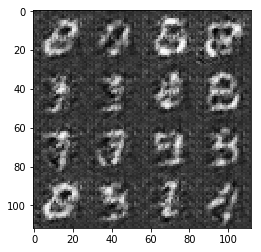

Epoch 2/2 Step 725/936: Discriminator Loss: 0.0448. Generator Loss: 4.0032
Epoch 2/2 Step 730/936: Discriminator Loss: 0.0209. Generator Loss: 6.2118
Epoch 2/2 Step 735/936: Discriminator Loss: 0.0742. Generator Loss: 3.5082
generator out (?, 28, 28, 1)


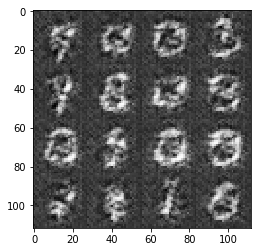

Epoch 2/2 Step 740/936: Discriminator Loss: 0.0198. Generator Loss: 5.3072
Epoch 2/2 Step 745/936: Discriminator Loss: 0.0539. Generator Loss: 4.1738
Epoch 2/2 Step 750/936: Discriminator Loss: 0.0450. Generator Loss: 4.4119
generator out (?, 28, 28, 1)


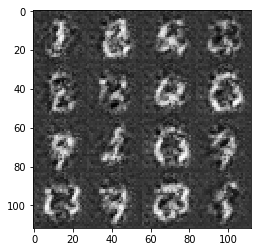

Epoch 2/2 Step 755/936: Discriminator Loss: 0.2169. Generator Loss: 2.1294
Epoch 2/2 Step 760/936: Discriminator Loss: 0.0259. Generator Loss: 5.3668
Epoch 2/2 Step 765/936: Discriminator Loss: 0.0345. Generator Loss: 5.5393
generator out (?, 28, 28, 1)


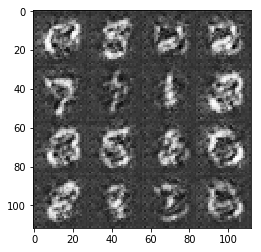

Epoch 2/2 Step 770/936: Discriminator Loss: 0.1416. Generator Loss: 5.7431
Epoch 2/2 Step 775/936: Discriminator Loss: 0.1216. Generator Loss: 2.8232
Epoch 2/2 Step 780/936: Discriminator Loss: 0.0378. Generator Loss: 4.5208
generator out (?, 28, 28, 1)


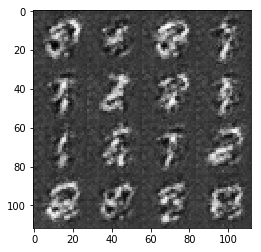

Epoch 2/2 Step 785/936: Discriminator Loss: 0.3133. Generator Loss: 1.6424
Epoch 2/2 Step 790/936: Discriminator Loss: 0.0209. Generator Loss: 5.1061
Epoch 2/2 Step 795/936: Discriminator Loss: 0.0474. Generator Loss: 3.9637
generator out (?, 28, 28, 1)


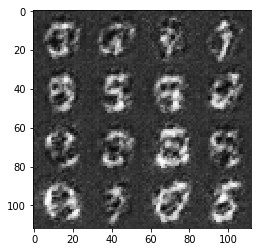

Epoch 2/2 Step 800/936: Discriminator Loss: 0.0588. Generator Loss: 3.5139
Epoch 2/2 Step 805/936: Discriminator Loss: 0.0321. Generator Loss: 5.2359
Epoch 2/2 Step 810/936: Discriminator Loss: 0.1091. Generator Loss: 2.7701
generator out (?, 28, 28, 1)


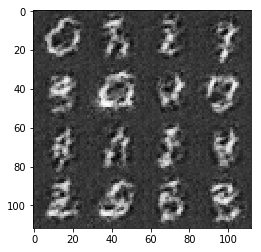

Epoch 2/2 Step 815/936: Discriminator Loss: 0.0256. Generator Loss: 5.6206
Epoch 2/2 Step 820/936: Discriminator Loss: 0.0605. Generator Loss: 3.3359
Epoch 2/2 Step 825/936: Discriminator Loss: 0.1900. Generator Loss: 2.1677
generator out (?, 28, 28, 1)


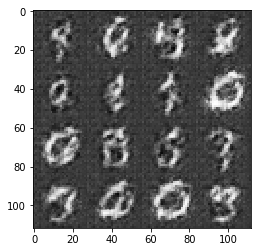

Epoch 2/2 Step 830/936: Discriminator Loss: 0.0105. Generator Loss: 6.2659
Epoch 2/2 Step 835/936: Discriminator Loss: 0.0222. Generator Loss: 5.7277
Epoch 2/2 Step 840/936: Discriminator Loss: 0.0108. Generator Loss: 5.7216
generator out (?, 28, 28, 1)


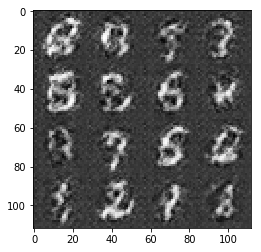

Epoch 2/2 Step 845/936: Discriminator Loss: 0.0251. Generator Loss: 5.2148
Epoch 2/2 Step 850/936: Discriminator Loss: 0.0207. Generator Loss: 4.6770
Epoch 2/2 Step 855/936: Discriminator Loss: 0.0209. Generator Loss: 7.1929
generator out (?, 28, 28, 1)


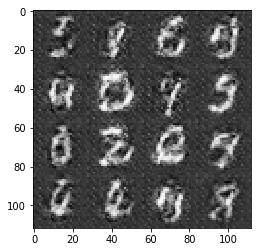

Epoch 2/2 Step 860/936: Discriminator Loss: 0.0200. Generator Loss: 5.1239
Epoch 2/2 Step 865/936: Discriminator Loss: 0.0405. Generator Loss: 3.8421
Epoch 2/2 Step 870/936: Discriminator Loss: 0.0190. Generator Loss: 9.5820
generator out (?, 28, 28, 1)


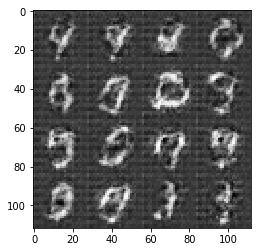

Epoch 2/2 Step 875/936: Discriminator Loss: 0.0075. Generator Loss: 6.8701
Epoch 2/2 Step 880/936: Discriminator Loss: 0.0281. Generator Loss: 5.8591
Epoch 2/2 Step 885/936: Discriminator Loss: 0.0156. Generator Loss: 5.5400
generator out (?, 28, 28, 1)


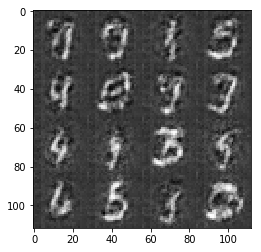

Epoch 2/2 Step 890/936: Discriminator Loss: 0.0215. Generator Loss: 5.5825
Epoch 2/2 Step 895/936: Discriminator Loss: 0.0144. Generator Loss: 5.5624
Epoch 2/2 Step 900/936: Discriminator Loss: 0.0864. Generator Loss: 3.0353
generator out (?, 28, 28, 1)


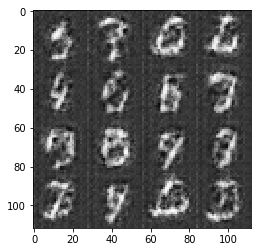

Epoch 2/2 Step 905/936: Discriminator Loss: 0.5370. Generator Loss: 7.3842
Epoch 2/2 Step 910/936: Discriminator Loss: 5.4964. Generator Loss: 11.4355
Epoch 2/2 Step 915/936: Discriminator Loss: 0.7717. Generator Loss: 2.2758
generator out (?, 28, 28, 1)


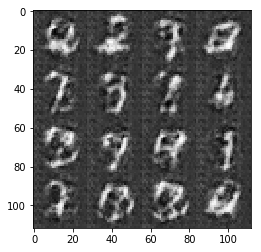

Epoch 2/2 Step 920/936: Discriminator Loss: 0.6769. Generator Loss: 2.1395
Epoch 2/2 Step 925/936: Discriminator Loss: 0.4961. Generator Loss: 1.7219
Epoch 2/2 Step 930/936: Discriminator Loss: 0.4140. Generator Loss: 2.2496
generator out (?, 28, 28, 1)


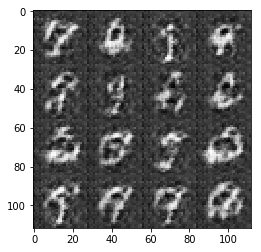

Epoch 2/2 Step 935/936: Discriminator Loss: 0.4090. Generator Loss: 2.1574


In [28]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

generator out (?, 28, 28, 3)
discriminator (?, 4, 4, 512)
discriminator (?, 4, 4, 512)
Epoch 1/1 Step 0/1582: Discriminator Loss: 2.3650. Generator Loss: 0.1902
generator out (?, 28, 28, 3)


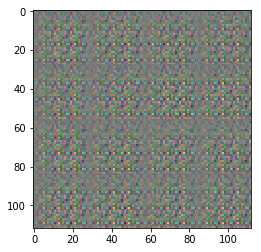

Epoch 1/1 Step 5/1582: Discriminator Loss: 0.0836. Generator Loss: 10.0951
Epoch 1/1 Step 10/1582: Discriminator Loss: 0.0159. Generator Loss: 12.1584
Epoch 1/1 Step 15/1582: Discriminator Loss: 0.1020. Generator Loss: 27.5123
generator out (?, 28, 28, 3)


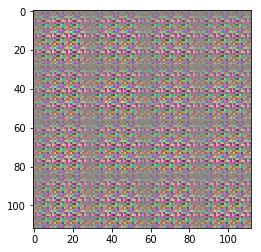

Epoch 1/1 Step 20/1582: Discriminator Loss: 0.0060. Generator Loss: 19.5392
Epoch 1/1 Step 25/1582: Discriminator Loss: 0.1052. Generator Loss: 31.1536
Epoch 1/1 Step 30/1582: Discriminator Loss: 3.5667. Generator Loss: 35.0375
generator out (?, 28, 28, 3)


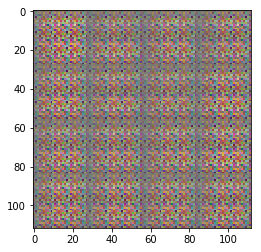

Epoch 1/1 Step 35/1582: Discriminator Loss: 0.0170. Generator Loss: 20.7391
Epoch 1/1 Step 40/1582: Discriminator Loss: 0.5225. Generator Loss: 21.8079
Epoch 1/1 Step 45/1582: Discriminator Loss: 0.4210. Generator Loss: 18.5251
generator out (?, 28, 28, 3)


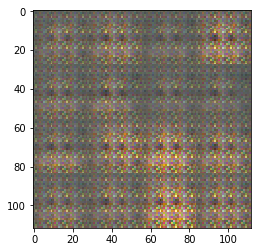

Epoch 1/1 Step 50/1582: Discriminator Loss: 0.9878. Generator Loss: 2.5520
Epoch 1/1 Step 55/1582: Discriminator Loss: 3.9118. Generator Loss: 17.1622
Epoch 1/1 Step 60/1582: Discriminator Loss: 0.7696. Generator Loss: 10.5027
generator out (?, 28, 28, 3)


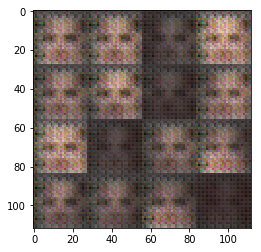

Epoch 1/1 Step 65/1582: Discriminator Loss: 0.1458. Generator Loss: 5.7481
Epoch 1/1 Step 70/1582: Discriminator Loss: 1.4149. Generator Loss: 0.5399
Epoch 1/1 Step 75/1582: Discriminator Loss: 4.3203. Generator Loss: 21.3476
generator out (?, 28, 28, 3)


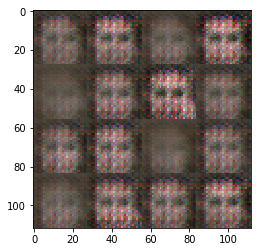

Epoch 1/1 Step 80/1582: Discriminator Loss: 0.1453. Generator Loss: 2.8243
Epoch 1/1 Step 85/1582: Discriminator Loss: 0.1621. Generator Loss: 4.8857
Epoch 1/1 Step 90/1582: Discriminator Loss: 0.1688. Generator Loss: 2.4133
generator out (?, 28, 28, 3)


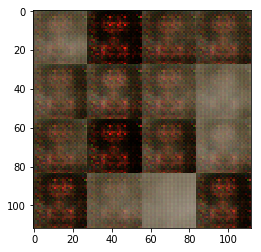

Epoch 1/1 Step 95/1582: Discriminator Loss: 0.9367. Generator Loss: 1.0434
Epoch 1/1 Step 100/1582: Discriminator Loss: 3.6084. Generator Loss: 11.5862
Epoch 1/1 Step 105/1582: Discriminator Loss: 0.6536. Generator Loss: 8.5222
generator out (?, 28, 28, 3)


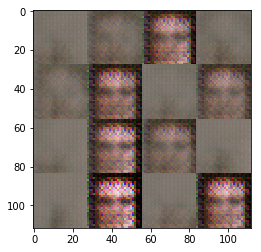

Epoch 1/1 Step 110/1582: Discriminator Loss: 0.0557. Generator Loss: 3.5098
Epoch 1/1 Step 115/1582: Discriminator Loss: 0.2434. Generator Loss: 4.4394
Epoch 1/1 Step 120/1582: Discriminator Loss: 0.2205. Generator Loss: 2.4074
generator out (?, 28, 28, 3)


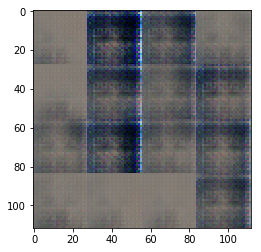

Epoch 1/1 Step 125/1582: Discriminator Loss: 0.1295. Generator Loss: 8.4939
Epoch 1/1 Step 130/1582: Discriminator Loss: 0.0294. Generator Loss: 4.8546
Epoch 1/1 Step 135/1582: Discriminator Loss: 0.1277. Generator Loss: 4.5154
generator out (?, 28, 28, 3)


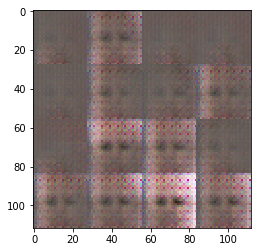

Epoch 1/1 Step 140/1582: Discriminator Loss: 12.7838. Generator Loss: 15.8381
Epoch 1/1 Step 145/1582: Discriminator Loss: 0.8987. Generator Loss: 0.7769
Epoch 1/1 Step 150/1582: Discriminator Loss: 0.8154. Generator Loss: 1.5998
generator out (?, 28, 28, 3)


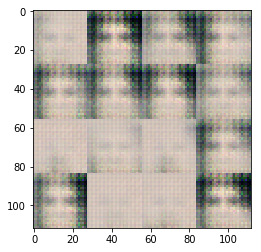

Epoch 1/1 Step 155/1582: Discriminator Loss: 0.7366. Generator Loss: 1.1208
Epoch 1/1 Step 160/1582: Discriminator Loss: 6.5597. Generator Loss: 0.0288
Epoch 1/1 Step 165/1582: Discriminator Loss: 0.3433. Generator Loss: 2.3163
generator out (?, 28, 28, 3)


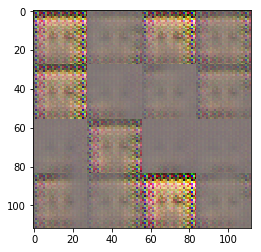

Epoch 1/1 Step 170/1582: Discriminator Loss: 0.3713. Generator Loss: 2.6135
Epoch 1/1 Step 175/1582: Discriminator Loss: 0.2814. Generator Loss: 1.9526
Epoch 1/1 Step 180/1582: Discriminator Loss: 0.2678. Generator Loss: 2.2759
generator out (?, 28, 28, 3)


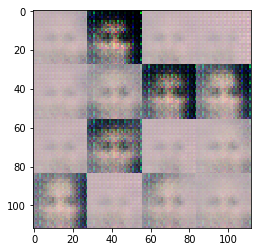

Epoch 1/1 Step 185/1582: Discriminator Loss: 0.2705. Generator Loss: 2.3212
Epoch 1/1 Step 190/1582: Discriminator Loss: 0.4784. Generator Loss: 2.3396
Epoch 1/1 Step 195/1582: Discriminator Loss: 0.1814. Generator Loss: 5.4372
generator out (?, 28, 28, 3)


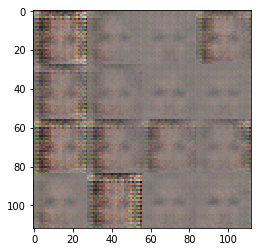

Epoch 1/1 Step 200/1582: Discriminator Loss: 5.4387. Generator Loss: 7.9050
Epoch 1/1 Step 205/1582: Discriminator Loss: 0.4140. Generator Loss: 3.3060
Epoch 1/1 Step 210/1582: Discriminator Loss: 0.4495. Generator Loss: 1.7906
generator out (?, 28, 28, 3)


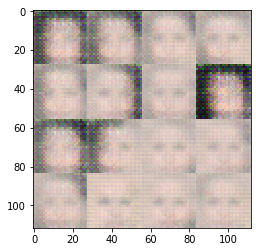

Epoch 1/1 Step 215/1582: Discriminator Loss: 0.0828. Generator Loss: 5.7406
Epoch 1/1 Step 220/1582: Discriminator Loss: 0.4231. Generator Loss: 1.3938
Epoch 1/1 Step 225/1582: Discriminator Loss: 0.0887. Generator Loss: 4.0802
generator out (?, 28, 28, 3)


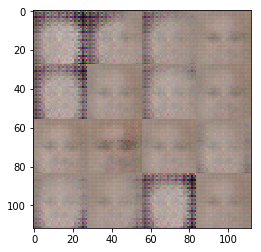

Epoch 1/1 Step 230/1582: Discriminator Loss: 2.3955. Generator Loss: 0.1361
Epoch 1/1 Step 235/1582: Discriminator Loss: 0.5885. Generator Loss: 1.9026
Epoch 1/1 Step 240/1582: Discriminator Loss: 0.5601. Generator Loss: 1.1353
generator out (?, 28, 28, 3)


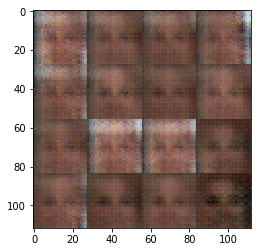

Epoch 1/1 Step 245/1582: Discriminator Loss: 1.0554. Generator Loss: 0.7804
Epoch 1/1 Step 250/1582: Discriminator Loss: 1.2926. Generator Loss: 2.8036
Epoch 1/1 Step 255/1582: Discriminator Loss: 1.2190. Generator Loss: 4.8333
generator out (?, 28, 28, 3)


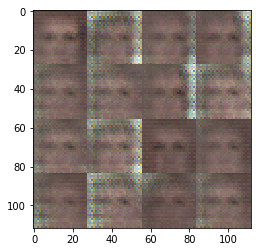

Epoch 1/1 Step 260/1582: Discriminator Loss: 0.3250. Generator Loss: 1.6205
Epoch 1/1 Step 265/1582: Discriminator Loss: 0.4704. Generator Loss: 1.2497
Epoch 1/1 Step 270/1582: Discriminator Loss: 4.8560. Generator Loss: 8.2492
generator out (?, 28, 28, 3)


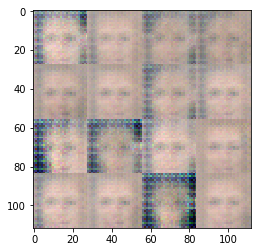

Epoch 1/1 Step 275/1582: Discriminator Loss: 1.0191. Generator Loss: 1.3872
Epoch 1/1 Step 280/1582: Discriminator Loss: 0.5993. Generator Loss: 5.0500
Epoch 1/1 Step 285/1582: Discriminator Loss: 1.0519. Generator Loss: 1.0411
generator out (?, 28, 28, 3)


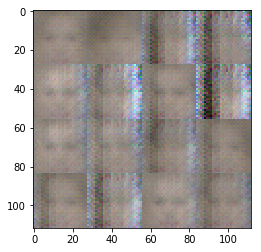

Epoch 1/1 Step 290/1582: Discriminator Loss: 1.2747. Generator Loss: 0.4359
Epoch 1/1 Step 295/1582: Discriminator Loss: 2.3897. Generator Loss: 0.1387
Epoch 1/1 Step 300/1582: Discriminator Loss: 1.8226. Generator Loss: 5.2645
generator out (?, 28, 28, 3)


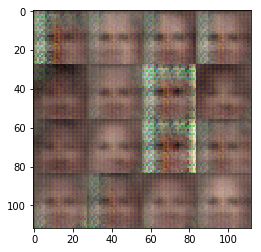

Epoch 1/1 Step 305/1582: Discriminator Loss: 1.1759. Generator Loss: 0.5136
Epoch 1/1 Step 310/1582: Discriminator Loss: 0.8037. Generator Loss: 1.6345
Epoch 1/1 Step 315/1582: Discriminator Loss: 0.3682. Generator Loss: 4.2509
generator out (?, 28, 28, 3)


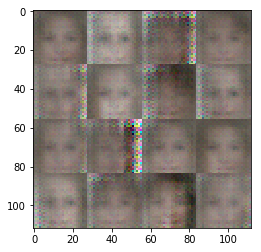

Epoch 1/1 Step 320/1582: Discriminator Loss: 0.3222. Generator Loss: 1.9247
Epoch 1/1 Step 325/1582: Discriminator Loss: 0.3063. Generator Loss: 5.2606
Epoch 1/1 Step 330/1582: Discriminator Loss: 0.6826. Generator Loss: 3.4745
generator out (?, 28, 28, 3)


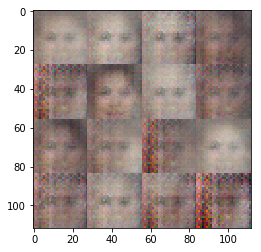

Epoch 1/1 Step 335/1582: Discriminator Loss: 2.4118. Generator Loss: 5.1604
Epoch 1/1 Step 340/1582: Discriminator Loss: 1.5750. Generator Loss: 0.3096
Epoch 1/1 Step 345/1582: Discriminator Loss: 1.2135. Generator Loss: 1.4253
generator out (?, 28, 28, 3)


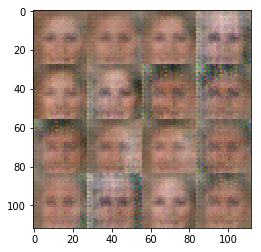

Epoch 1/1 Step 350/1582: Discriminator Loss: 0.2467. Generator Loss: 6.4595
Epoch 1/1 Step 355/1582: Discriminator Loss: 0.3459. Generator Loss: 2.1117
Epoch 1/1 Step 360/1582: Discriminator Loss: 0.4263. Generator Loss: 1.4821
generator out (?, 28, 28, 3)


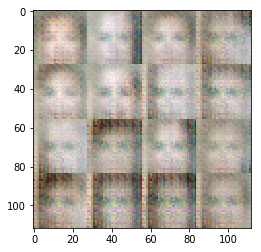

Epoch 1/1 Step 365/1582: Discriminator Loss: 1.2651. Generator Loss: 2.5795
Epoch 1/1 Step 370/1582: Discriminator Loss: 1.6943. Generator Loss: 0.3801
Epoch 1/1 Step 375/1582: Discriminator Loss: 1.2730. Generator Loss: 0.8405
generator out (?, 28, 28, 3)


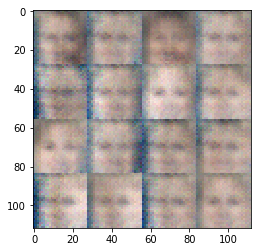

Epoch 1/1 Step 380/1582: Discriminator Loss: 0.6424. Generator Loss: 2.9060
Epoch 1/1 Step 385/1582: Discriminator Loss: 1.1250. Generator Loss: 0.6517
Epoch 1/1 Step 390/1582: Discriminator Loss: 0.9002. Generator Loss: 0.9366
generator out (?, 28, 28, 3)


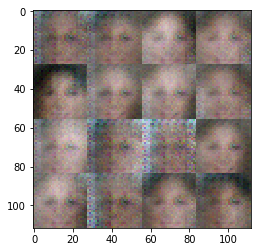

Epoch 1/1 Step 395/1582: Discriminator Loss: 1.0761. Generator Loss: 1.5590
Epoch 1/1 Step 400/1582: Discriminator Loss: 0.8686. Generator Loss: 1.0548
Epoch 1/1 Step 405/1582: Discriminator Loss: 1.5441. Generator Loss: 0.3219
generator out (?, 28, 28, 3)


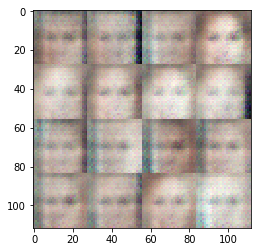

Epoch 1/1 Step 410/1582: Discriminator Loss: 0.9544. Generator Loss: 0.8260
Epoch 1/1 Step 415/1582: Discriminator Loss: 1.2243. Generator Loss: 0.7305
Epoch 1/1 Step 420/1582: Discriminator Loss: 1.0065. Generator Loss: 1.3300
generator out (?, 28, 28, 3)


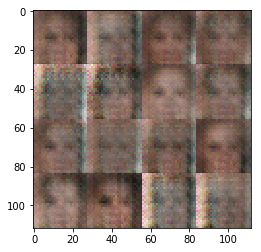

Epoch 1/1 Step 425/1582: Discriminator Loss: 0.4274. Generator Loss: 3.1490
Epoch 1/1 Step 430/1582: Discriminator Loss: 0.4880. Generator Loss: 1.3443
Epoch 1/1 Step 435/1582: Discriminator Loss: 0.6992. Generator Loss: 1.0182
generator out (?, 28, 28, 3)


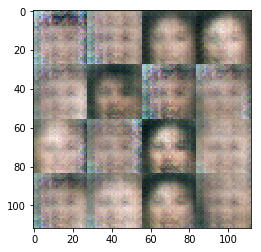

Epoch 1/1 Step 440/1582: Discriminator Loss: 0.0642. Generator Loss: 6.9816
Epoch 1/1 Step 445/1582: Discriminator Loss: 1.3983. Generator Loss: 0.4539
Epoch 1/1 Step 450/1582: Discriminator Loss: 0.4745. Generator Loss: 1.9985
generator out (?, 28, 28, 3)


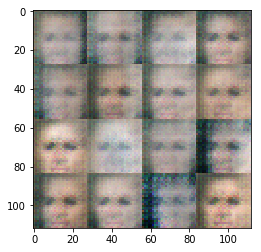

Epoch 1/1 Step 455/1582: Discriminator Loss: 1.2172. Generator Loss: 0.5390
Epoch 1/1 Step 460/1582: Discriminator Loss: 0.3639. Generator Loss: 6.4401
Epoch 1/1 Step 465/1582: Discriminator Loss: 0.3486. Generator Loss: 3.1166
generator out (?, 28, 28, 3)


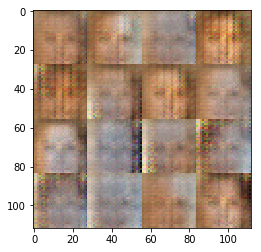

Epoch 1/1 Step 470/1582: Discriminator Loss: 0.4431. Generator Loss: 1.5933
Epoch 1/1 Step 475/1582: Discriminator Loss: 0.4787. Generator Loss: 1.5304
Epoch 1/1 Step 480/1582: Discriminator Loss: 0.3290. Generator Loss: 2.7656
generator out (?, 28, 28, 3)


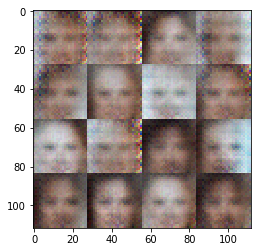

Epoch 1/1 Step 485/1582: Discriminator Loss: 1.1900. Generator Loss: 2.7536
Epoch 1/1 Step 490/1582: Discriminator Loss: 0.4471. Generator Loss: 1.7867
Epoch 1/1 Step 495/1582: Discriminator Loss: 1.0285. Generator Loss: 0.6088
generator out (?, 28, 28, 3)


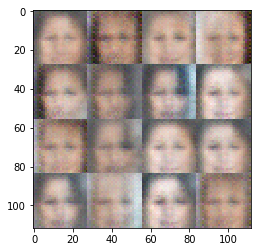

Epoch 1/1 Step 500/1582: Discriminator Loss: 0.5040. Generator Loss: 2.9273
Epoch 1/1 Step 505/1582: Discriminator Loss: 0.7263. Generator Loss: 1.1230
Epoch 1/1 Step 510/1582: Discriminator Loss: 1.1409. Generator Loss: 4.4084
generator out (?, 28, 28, 3)


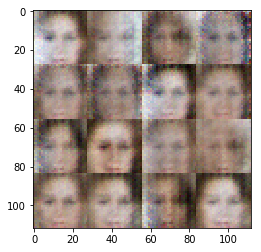

Epoch 1/1 Step 515/1582: Discriminator Loss: 0.6655. Generator Loss: 1.0902
Epoch 1/1 Step 520/1582: Discriminator Loss: 0.0505. Generator Loss: 4.1902
Epoch 1/1 Step 525/1582: Discriminator Loss: 0.5596. Generator Loss: 1.7502
generator out (?, 28, 28, 3)


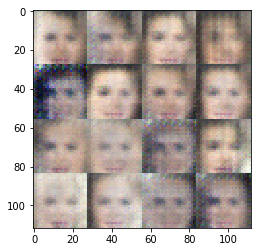

Epoch 1/1 Step 530/1582: Discriminator Loss: 0.1043. Generator Loss: 4.1880
Epoch 1/1 Step 535/1582: Discriminator Loss: 1.9018. Generator Loss: 4.7753
Epoch 1/1 Step 540/1582: Discriminator Loss: 0.3067. Generator Loss: 2.1890
generator out (?, 28, 28, 3)


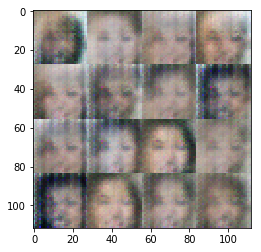

Epoch 1/1 Step 545/1582: Discriminator Loss: 0.0671. Generator Loss: 3.3334
Epoch 1/1 Step 550/1582: Discriminator Loss: 0.1137. Generator Loss: 5.0968
Epoch 1/1 Step 555/1582: Discriminator Loss: 1.0767. Generator Loss: 0.6449
generator out (?, 28, 28, 3)


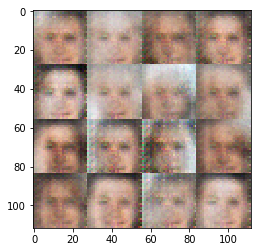

Epoch 1/1 Step 560/1582: Discriminator Loss: 0.2761. Generator Loss: 2.2190
Epoch 1/1 Step 565/1582: Discriminator Loss: 0.2341. Generator Loss: 1.8052
Epoch 1/1 Step 570/1582: Discriminator Loss: 0.0716. Generator Loss: 5.7364
generator out (?, 28, 28, 3)


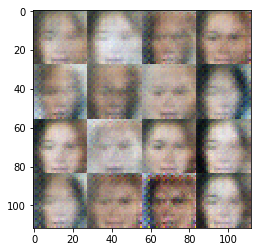

Epoch 1/1 Step 575/1582: Discriminator Loss: 1.9457. Generator Loss: 0.2910
Epoch 1/1 Step 580/1582: Discriminator Loss: 0.4408. Generator Loss: 5.3898
Epoch 1/1 Step 585/1582: Discriminator Loss: 0.4576. Generator Loss: 1.2043
generator out (?, 28, 28, 3)


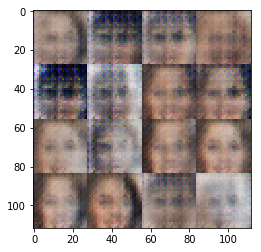

Epoch 1/1 Step 590/1582: Discriminator Loss: 0.1094. Generator Loss: 2.8628
Epoch 1/1 Step 595/1582: Discriminator Loss: 0.2857. Generator Loss: 3.8946
Epoch 1/1 Step 600/1582: Discriminator Loss: 6.1527. Generator Loss: 9.1119
generator out (?, 28, 28, 3)


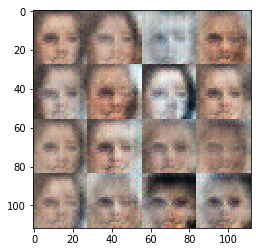

Epoch 1/1 Step 605/1582: Discriminator Loss: 0.6019. Generator Loss: 1.8176
Epoch 1/1 Step 610/1582: Discriminator Loss: 0.0207. Generator Loss: 7.0065
Epoch 1/1 Step 615/1582: Discriminator Loss: 0.4844. Generator Loss: 1.9828
generator out (?, 28, 28, 3)


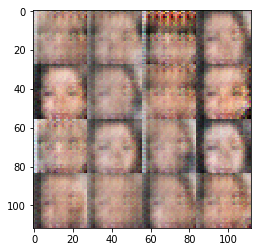

Epoch 1/1 Step 620/1582: Discriminator Loss: 1.1563. Generator Loss: 0.6984
Epoch 1/1 Step 625/1582: Discriminator Loss: 1.2532. Generator Loss: 0.9693
Epoch 1/1 Step 630/1582: Discriminator Loss: 1.0254. Generator Loss: 0.8303
generator out (?, 28, 28, 3)


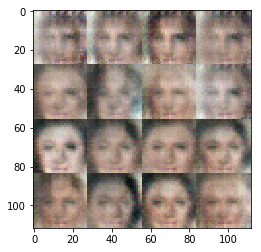

Epoch 1/1 Step 635/1582: Discriminator Loss: 0.5645. Generator Loss: 1.5562
Epoch 1/1 Step 640/1582: Discriminator Loss: 0.1662. Generator Loss: 4.1353
Epoch 1/1 Step 645/1582: Discriminator Loss: 0.1652. Generator Loss: 2.4576
generator out (?, 28, 28, 3)


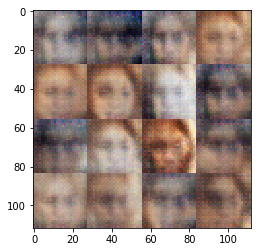

Epoch 1/1 Step 650/1582: Discriminator Loss: 0.6075. Generator Loss: 1.7859
Epoch 1/1 Step 655/1582: Discriminator Loss: 1.2414. Generator Loss: 0.5816
Epoch 1/1 Step 660/1582: Discriminator Loss: 1.9404. Generator Loss: 7.2419
generator out (?, 28, 28, 3)


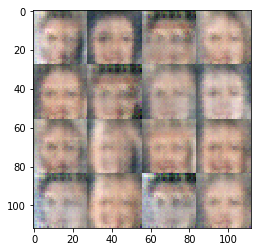

Epoch 1/1 Step 665/1582: Discriminator Loss: 0.4783. Generator Loss: 2.2886
Epoch 1/1 Step 670/1582: Discriminator Loss: 0.6941. Generator Loss: 0.8283
Epoch 1/1 Step 675/1582: Discriminator Loss: 0.1163. Generator Loss: 3.3322
generator out (?, 28, 28, 3)


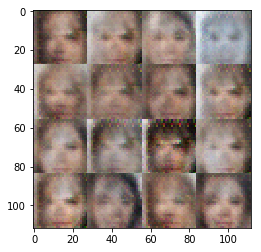

Epoch 1/1 Step 680/1582: Discriminator Loss: 1.7651. Generator Loss: 5.2627
Epoch 1/1 Step 685/1582: Discriminator Loss: 0.0600. Generator Loss: 4.6215
Epoch 1/1 Step 690/1582: Discriminator Loss: 4.0657. Generator Loss: 8.9132
generator out (?, 28, 28, 3)


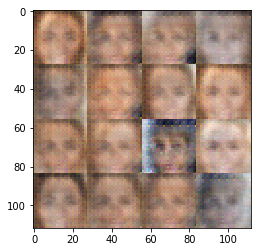

Epoch 1/1 Step 695/1582: Discriminator Loss: 0.8897. Generator Loss: 1.2459
Epoch 1/1 Step 700/1582: Discriminator Loss: 0.9910. Generator Loss: 1.4081
Epoch 1/1 Step 705/1582: Discriminator Loss: 0.5701. Generator Loss: 1.6163
generator out (?, 28, 28, 3)


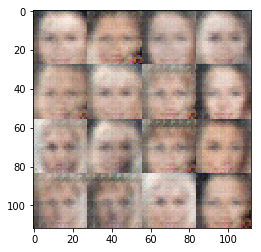

Epoch 1/1 Step 710/1582: Discriminator Loss: 0.2388. Generator Loss: 4.6422
Epoch 1/1 Step 715/1582: Discriminator Loss: 0.7341. Generator Loss: 1.2545
Epoch 1/1 Step 720/1582: Discriminator Loss: 0.4852. Generator Loss: 1.4562
generator out (?, 28, 28, 3)


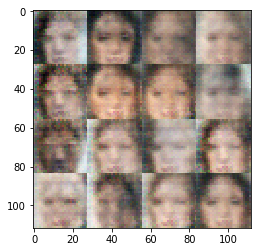

Epoch 1/1 Step 725/1582: Discriminator Loss: 0.8224. Generator Loss: 3.6153
Epoch 1/1 Step 730/1582: Discriminator Loss: 0.6474. Generator Loss: 1.1409
Epoch 1/1 Step 735/1582: Discriminator Loss: 0.7260. Generator Loss: 2.1184
generator out (?, 28, 28, 3)


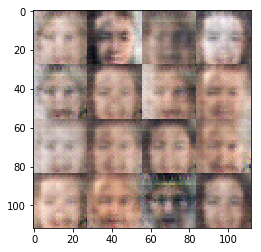

Epoch 1/1 Step 740/1582: Discriminator Loss: 0.8490. Generator Loss: 6.3981
Epoch 1/1 Step 745/1582: Discriminator Loss: 0.1707. Generator Loss: 6.0751
Epoch 1/1 Step 750/1582: Discriminator Loss: 0.0824. Generator Loss: 3.4469
generator out (?, 28, 28, 3)


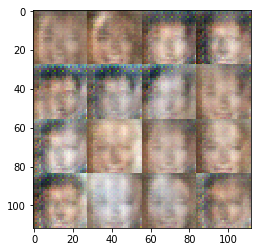

Epoch 1/1 Step 755/1582: Discriminator Loss: 0.2961. Generator Loss: 2.1325
Epoch 1/1 Step 760/1582: Discriminator Loss: 0.1656. Generator Loss: 2.9656
Epoch 1/1 Step 765/1582: Discriminator Loss: 0.0975. Generator Loss: 4.0040
generator out (?, 28, 28, 3)


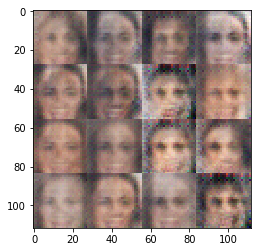

Epoch 1/1 Step 770/1582: Discriminator Loss: 0.9978. Generator Loss: 0.8119
Epoch 1/1 Step 775/1582: Discriminator Loss: 0.6382. Generator Loss: 1.2768
Epoch 1/1 Step 780/1582: Discriminator Loss: 0.1110. Generator Loss: 4.2559
generator out (?, 28, 28, 3)


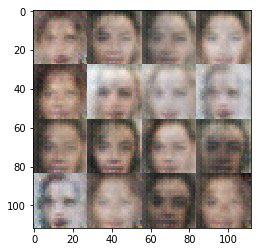

Epoch 1/1 Step 785/1582: Discriminator Loss: 0.6180. Generator Loss: 1.7152
Epoch 1/1 Step 790/1582: Discriminator Loss: 0.0397. Generator Loss: 6.4695
Epoch 1/1 Step 795/1582: Discriminator Loss: 0.1695. Generator Loss: 4.2947
generator out (?, 28, 28, 3)


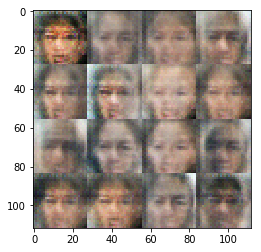

Epoch 1/1 Step 800/1582: Discriminator Loss: 0.3055. Generator Loss: 2.4190
Epoch 1/1 Step 805/1582: Discriminator Loss: 0.8774. Generator Loss: 4.4713
Epoch 1/1 Step 810/1582: Discriminator Loss: 0.1751. Generator Loss: 5.7145
generator out (?, 28, 28, 3)


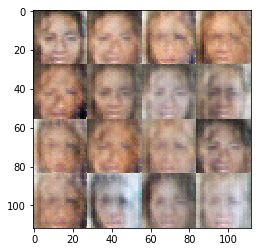

Epoch 1/1 Step 815/1582: Discriminator Loss: 0.3733. Generator Loss: 3.2756
Epoch 1/1 Step 820/1582: Discriminator Loss: 0.0461. Generator Loss: 4.7674
Epoch 1/1 Step 825/1582: Discriminator Loss: 0.4525. Generator Loss: 1.2675
generator out (?, 28, 28, 3)


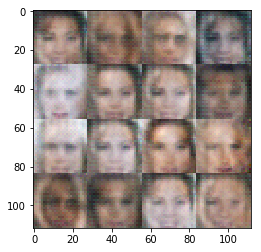

Epoch 1/1 Step 830/1582: Discriminator Loss: 0.6855. Generator Loss: 0.9610
Epoch 1/1 Step 835/1582: Discriminator Loss: 2.9983. Generator Loss: 0.2144
Epoch 1/1 Step 840/1582: Discriminator Loss: 0.4610. Generator Loss: 2.5991
generator out (?, 28, 28, 3)


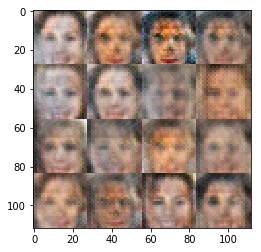

Epoch 1/1 Step 845/1582: Discriminator Loss: 1.7750. Generator Loss: 6.0153
Epoch 1/1 Step 850/1582: Discriminator Loss: 0.6382. Generator Loss: 0.9258
Epoch 1/1 Step 855/1582: Discriminator Loss: 0.6774. Generator Loss: 1.0861
generator out (?, 28, 28, 3)


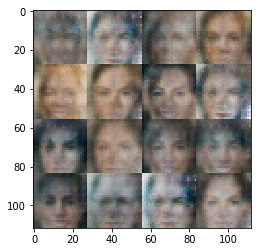

Epoch 1/1 Step 860/1582: Discriminator Loss: 1.0155. Generator Loss: 0.6115
Epoch 1/1 Step 865/1582: Discriminator Loss: 4.0275. Generator Loss: 6.6858
Epoch 1/1 Step 870/1582: Discriminator Loss: 1.1237. Generator Loss: 0.6780
generator out (?, 28, 28, 3)


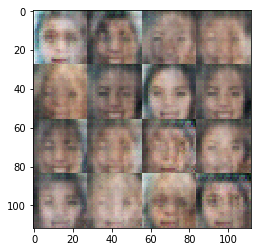

Epoch 1/1 Step 875/1582: Discriminator Loss: 0.0424. Generator Loss: 5.5680
Epoch 1/1 Step 880/1582: Discriminator Loss: 0.3007. Generator Loss: 2.1658
Epoch 1/1 Step 885/1582: Discriminator Loss: 1.2166. Generator Loss: 4.7658
generator out (?, 28, 28, 3)


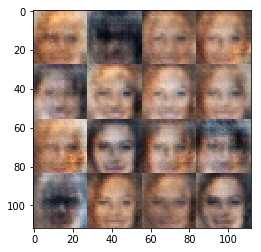

Epoch 1/1 Step 890/1582: Discriminator Loss: 0.3035. Generator Loss: 5.9028
Epoch 1/1 Step 895/1582: Discriminator Loss: 0.1316. Generator Loss: 2.9963
Epoch 1/1 Step 900/1582: Discriminator Loss: 0.6160. Generator Loss: 1.0813
generator out (?, 28, 28, 3)


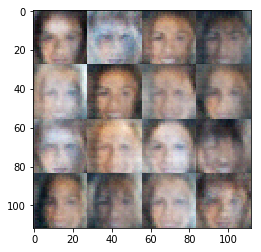

Epoch 1/1 Step 905/1582: Discriminator Loss: 0.5741. Generator Loss: 1.4414
Epoch 1/1 Step 910/1582: Discriminator Loss: 0.1446. Generator Loss: 3.4781
Epoch 1/1 Step 915/1582: Discriminator Loss: 0.8993. Generator Loss: 2.3547
generator out (?, 28, 28, 3)


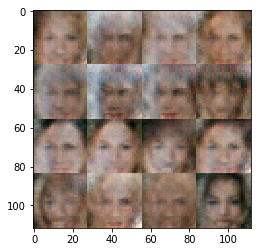

Epoch 1/1 Step 920/1582: Discriminator Loss: 1.2458. Generator Loss: 0.4852
Epoch 1/1 Step 925/1582: Discriminator Loss: 0.3059. Generator Loss: 3.9633
Epoch 1/1 Step 930/1582: Discriminator Loss: 0.3248. Generator Loss: 7.1984
generator out (?, 28, 28, 3)


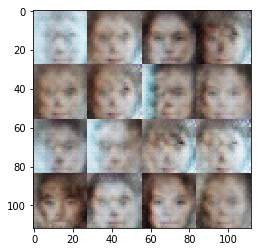

Epoch 1/1 Step 935/1582: Discriminator Loss: 0.1975. Generator Loss: 4.2590
Epoch 1/1 Step 940/1582: Discriminator Loss: 0.0246. Generator Loss: 8.3307
Epoch 1/1 Step 945/1582: Discriminator Loss: 0.0755. Generator Loss: 5.1530
generator out (?, 28, 28, 3)


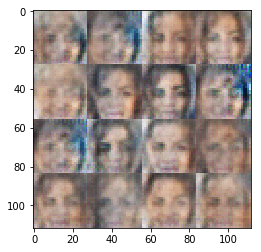

Epoch 1/1 Step 950/1582: Discriminator Loss: 0.0243. Generator Loss: 5.8790
Epoch 1/1 Step 955/1582: Discriminator Loss: 0.0209. Generator Loss: 4.8373
Epoch 1/1 Step 960/1582: Discriminator Loss: 0.1299. Generator Loss: 2.4059
generator out (?, 28, 28, 3)


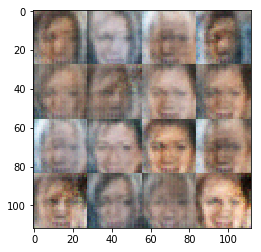

Epoch 1/1 Step 965/1582: Discriminator Loss: 0.6824. Generator Loss: 8.7410
Epoch 1/1 Step 970/1582: Discriminator Loss: 3.0741. Generator Loss: 0.2622
Epoch 1/1 Step 975/1582: Discriminator Loss: 1.2473. Generator Loss: 1.5268
generator out (?, 28, 28, 3)


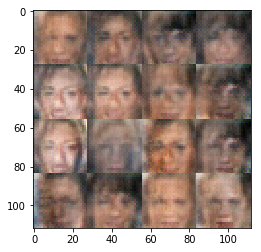

Epoch 1/1 Step 980/1582: Discriminator Loss: 0.9568. Generator Loss: 1.7067
Epoch 1/1 Step 985/1582: Discriminator Loss: 1.3157. Generator Loss: 3.5698
Epoch 1/1 Step 990/1582: Discriminator Loss: 0.7687. Generator Loss: 0.9117
generator out (?, 28, 28, 3)


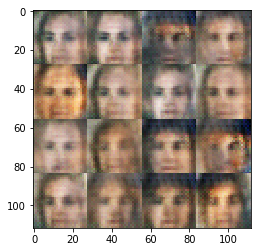

Epoch 1/1 Step 995/1582: Discriminator Loss: 0.2227. Generator Loss: 2.3284
Epoch 1/1 Step 1000/1582: Discriminator Loss: 0.2381. Generator Loss: 1.9285
Epoch 1/1 Step 1005/1582: Discriminator Loss: 0.3007. Generator Loss: 3.9459
generator out (?, 28, 28, 3)


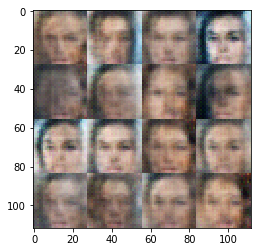

Epoch 1/1 Step 1010/1582: Discriminator Loss: 0.2543. Generator Loss: 2.1428
Epoch 1/1 Step 1015/1582: Discriminator Loss: 0.3868. Generator Loss: 2.7515
Epoch 1/1 Step 1020/1582: Discriminator Loss: 1.0184. Generator Loss: 0.5414
generator out (?, 28, 28, 3)


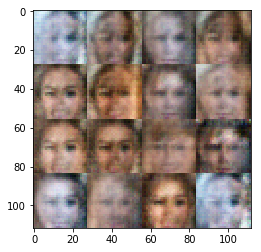

Epoch 1/1 Step 1025/1582: Discriminator Loss: 0.7238. Generator Loss: 0.8899
Epoch 1/1 Step 1030/1582: Discriminator Loss: 0.2531. Generator Loss: 3.8127
Epoch 1/1 Step 1035/1582: Discriminator Loss: 0.2208. Generator Loss: 5.2033
generator out (?, 28, 28, 3)


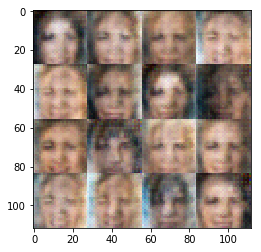

Epoch 1/1 Step 1040/1582: Discriminator Loss: 0.0870. Generator Loss: 6.1368
Epoch 1/1 Step 1045/1582: Discriminator Loss: 0.2981. Generator Loss: 2.1223
Epoch 1/1 Step 1050/1582: Discriminator Loss: 1.1819. Generator Loss: 0.5639
generator out (?, 28, 28, 3)


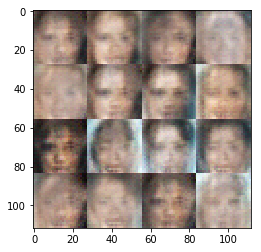

Epoch 1/1 Step 1055/1582: Discriminator Loss: 0.6477. Generator Loss: 1.2005
Epoch 1/1 Step 1060/1582: Discriminator Loss: 0.2028. Generator Loss: 4.2308
Epoch 1/1 Step 1065/1582: Discriminator Loss: 0.3390. Generator Loss: 2.0434
generator out (?, 28, 28, 3)


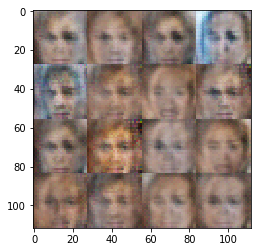

Epoch 1/1 Step 1070/1582: Discriminator Loss: 0.8413. Generator Loss: 5.3455
Epoch 1/1 Step 1075/1582: Discriminator Loss: 0.5297. Generator Loss: 1.1341
Epoch 1/1 Step 1080/1582: Discriminator Loss: 0.4764. Generator Loss: 1.3854
generator out (?, 28, 28, 3)


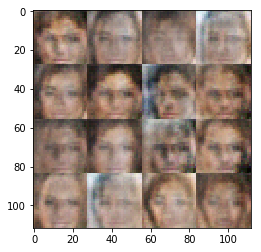

Epoch 1/1 Step 1085/1582: Discriminator Loss: 1.0478. Generator Loss: 0.7816
Epoch 1/1 Step 1090/1582: Discriminator Loss: 0.7583. Generator Loss: 5.2867
Epoch 1/1 Step 1095/1582: Discriminator Loss: 0.3999. Generator Loss: 1.7453
generator out (?, 28, 28, 3)


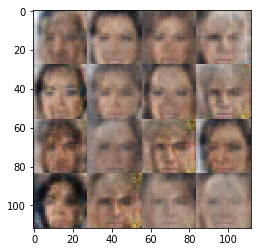

Epoch 1/1 Step 1100/1582: Discriminator Loss: 0.8461. Generator Loss: 0.7878
Epoch 1/1 Step 1105/1582: Discriminator Loss: 0.6457. Generator Loss: 6.5999
Epoch 1/1 Step 1110/1582: Discriminator Loss: 1.7657. Generator Loss: 7.1646
generator out (?, 28, 28, 3)


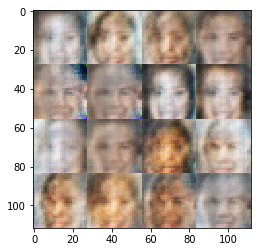

Epoch 1/1 Step 1115/1582: Discriminator Loss: 0.2779. Generator Loss: 2.2444
Epoch 1/1 Step 1120/1582: Discriminator Loss: 0.0543. Generator Loss: 6.7662
Epoch 1/1 Step 1125/1582: Discriminator Loss: 4.1742. Generator Loss: 9.7303
generator out (?, 28, 28, 3)


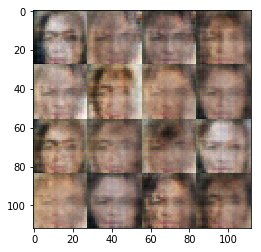

Epoch 1/1 Step 1130/1582: Discriminator Loss: 0.5824. Generator Loss: 1.1395
Epoch 1/1 Step 1135/1582: Discriminator Loss: 0.3847. Generator Loss: 1.7777
Epoch 1/1 Step 1140/1582: Discriminator Loss: 0.4416. Generator Loss: 1.5028
generator out (?, 28, 28, 3)


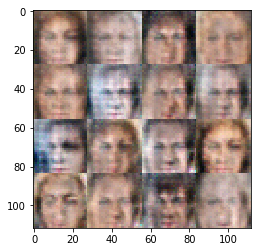

Epoch 1/1 Step 1145/1582: Discriminator Loss: 0.2817. Generator Loss: 6.5601
Epoch 1/1 Step 1150/1582: Discriminator Loss: 0.6075. Generator Loss: 1.2020
Epoch 1/1 Step 1155/1582: Discriminator Loss: 0.6442. Generator Loss: 4.0326
generator out (?, 28, 28, 3)


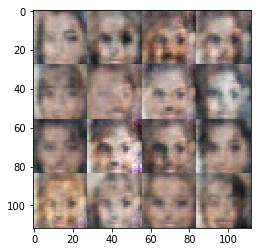

Epoch 1/1 Step 1160/1582: Discriminator Loss: 0.2740. Generator Loss: 2.0946
Epoch 1/1 Step 1165/1582: Discriminator Loss: 0.4138. Generator Loss: 1.3569
Epoch 1/1 Step 1170/1582: Discriminator Loss: 0.1260. Generator Loss: 3.6529
generator out (?, 28, 28, 3)


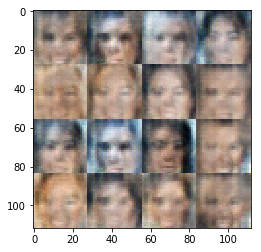

Epoch 1/1 Step 1175/1582: Discriminator Loss: 0.5748. Generator Loss: 1.4160
Epoch 1/1 Step 1180/1582: Discriminator Loss: 1.6234. Generator Loss: 0.3092
Epoch 1/1 Step 1185/1582: Discriminator Loss: 1.2254. Generator Loss: 0.5858
generator out (?, 28, 28, 3)


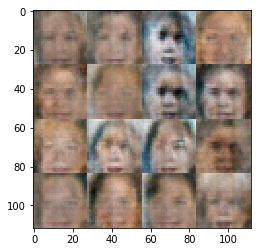

Epoch 1/1 Step 1190/1582: Discriminator Loss: 2.3886. Generator Loss: 0.3406
Epoch 1/1 Step 1195/1582: Discriminator Loss: 1.1440. Generator Loss: 4.3844
Epoch 1/1 Step 1200/1582: Discriminator Loss: 0.4276. Generator Loss: 3.3143
generator out (?, 28, 28, 3)


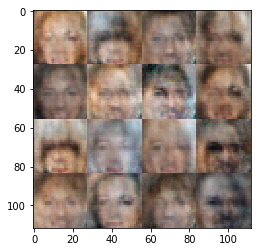

Epoch 1/1 Step 1205/1582: Discriminator Loss: 0.4428. Generator Loss: 3.4665
Epoch 1/1 Step 1210/1582: Discriminator Loss: 0.4530. Generator Loss: 1.4008
Epoch 1/1 Step 1215/1582: Discriminator Loss: 0.1601. Generator Loss: 3.0862
generator out (?, 28, 28, 3)


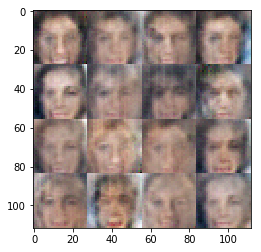

Epoch 1/1 Step 1220/1582: Discriminator Loss: 6.5800. Generator Loss: 10.0501
Epoch 1/1 Step 1225/1582: Discriminator Loss: 1.0041. Generator Loss: 0.9975
Epoch 1/1 Step 1230/1582: Discriminator Loss: 0.4287. Generator Loss: 1.9257
generator out (?, 28, 28, 3)


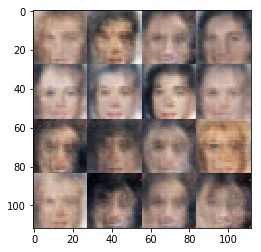

Epoch 1/1 Step 1235/1582: Discriminator Loss: 0.5815. Generator Loss: 1.7829
Epoch 1/1 Step 1240/1582: Discriminator Loss: 0.5563. Generator Loss: 2.3817
Epoch 1/1 Step 1245/1582: Discriminator Loss: 0.4131. Generator Loss: 1.6220
generator out (?, 28, 28, 3)


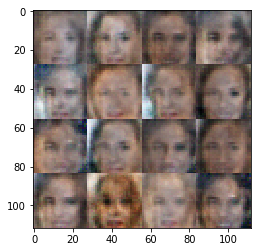

Epoch 1/1 Step 1250/1582: Discriminator Loss: 0.1423. Generator Loss: 6.5414
Epoch 1/1 Step 1255/1582: Discriminator Loss: 0.2162. Generator Loss: 2.0011
Epoch 1/1 Step 1260/1582: Discriminator Loss: 0.0804. Generator Loss: 5.7368
generator out (?, 28, 28, 3)


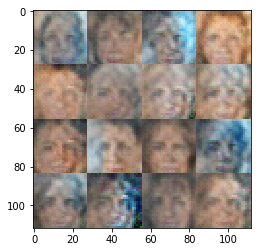

Epoch 1/1 Step 1265/1582: Discriminator Loss: 0.1044. Generator Loss: 4.0302
Epoch 1/1 Step 1270/1582: Discriminator Loss: 0.4172. Generator Loss: 4.0984
Epoch 1/1 Step 1275/1582: Discriminator Loss: 0.8944. Generator Loss: 0.7602
generator out (?, 28, 28, 3)


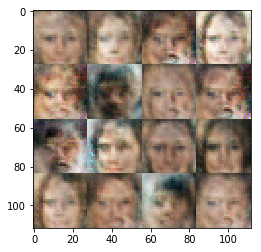

Epoch 1/1 Step 1280/1582: Discriminator Loss: 2.4464. Generator Loss: 5.2917
Epoch 1/1 Step 1285/1582: Discriminator Loss: 0.5951. Generator Loss: 1.8088
Epoch 1/1 Step 1290/1582: Discriminator Loss: 0.8549. Generator Loss: 1.5815
generator out (?, 28, 28, 3)


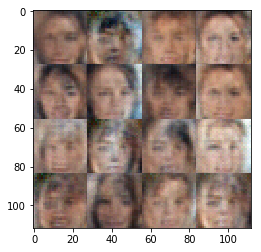

Epoch 1/1 Step 1295/1582: Discriminator Loss: 0.6039. Generator Loss: 1.6372
Epoch 1/1 Step 1300/1582: Discriminator Loss: 0.7302. Generator Loss: 1.0246
Epoch 1/1 Step 1305/1582: Discriminator Loss: 0.6339. Generator Loss: 1.2973
generator out (?, 28, 28, 3)


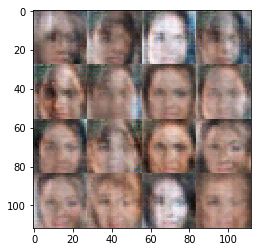

Epoch 1/1 Step 1310/1582: Discriminator Loss: 0.1319. Generator Loss: 3.6259
Epoch 1/1 Step 1315/1582: Discriminator Loss: 0.2224. Generator Loss: 4.1054
Epoch 1/1 Step 1320/1582: Discriminator Loss: 0.2935. Generator Loss: 1.8149
generator out (?, 28, 28, 3)


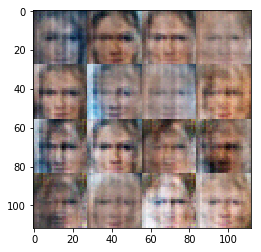

Epoch 1/1 Step 1325/1582: Discriminator Loss: 0.2291. Generator Loss: 2.4661
Epoch 1/1 Step 1330/1582: Discriminator Loss: 0.4275. Generator Loss: 4.9683
Epoch 1/1 Step 1335/1582: Discriminator Loss: 0.7790. Generator Loss: 0.8551
generator out (?, 28, 28, 3)


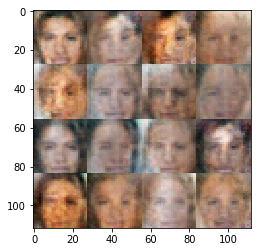

Epoch 1/1 Step 1340/1582: Discriminator Loss: 0.3110. Generator Loss: 2.4575
Epoch 1/1 Step 1345/1582: Discriminator Loss: 0.7878. Generator Loss: 3.4200
Epoch 1/1 Step 1350/1582: Discriminator Loss: 0.0839. Generator Loss: 4.1778
generator out (?, 28, 28, 3)


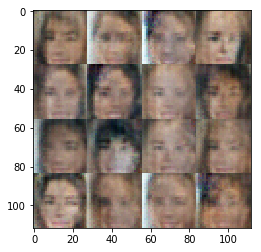

Epoch 1/1 Step 1355/1582: Discriminator Loss: 0.4964. Generator Loss: 2.1457
Epoch 1/1 Step 1360/1582: Discriminator Loss: 0.3275. Generator Loss: 3.1927
Epoch 1/1 Step 1365/1582: Discriminator Loss: 0.3590. Generator Loss: 1.7494
generator out (?, 28, 28, 3)


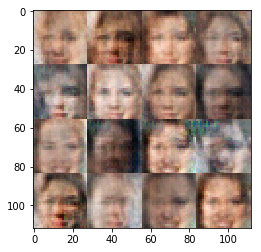

Epoch 1/1 Step 1370/1582: Discriminator Loss: 0.5546. Generator Loss: 1.2129
Epoch 1/1 Step 1375/1582: Discriminator Loss: 0.1305. Generator Loss: 4.9029
Epoch 1/1 Step 1380/1582: Discriminator Loss: 0.3404. Generator Loss: 1.7568
generator out (?, 28, 28, 3)


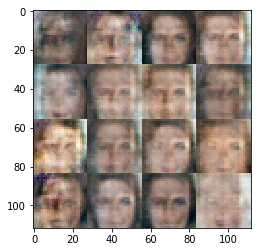

Epoch 1/1 Step 1385/1582: Discriminator Loss: 0.0325. Generator Loss: 8.6862
Epoch 1/1 Step 1390/1582: Discriminator Loss: 0.1608. Generator Loss: 3.4364
Epoch 1/1 Step 1395/1582: Discriminator Loss: 0.8419. Generator Loss: 1.1851
generator out (?, 28, 28, 3)


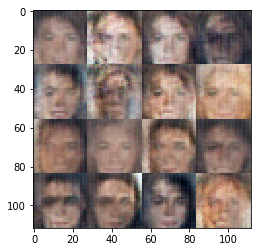

Epoch 1/1 Step 1400/1582: Discriminator Loss: 0.6275. Generator Loss: 1.6436
Epoch 1/1 Step 1405/1582: Discriminator Loss: 0.3544. Generator Loss: 3.3936
Epoch 1/1 Step 1410/1582: Discriminator Loss: 0.2048. Generator Loss: 3.7203
generator out (?, 28, 28, 3)


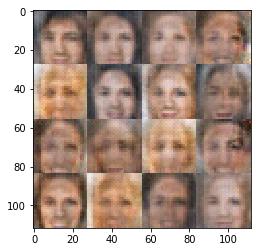

Epoch 1/1 Step 1415/1582: Discriminator Loss: 1.4959. Generator Loss: 6.2879
Epoch 1/1 Step 1420/1582: Discriminator Loss: 0.2400. Generator Loss: 4.2665
Epoch 1/1 Step 1425/1582: Discriminator Loss: 0.8812. Generator Loss: 3.5654
generator out (?, 28, 28, 3)


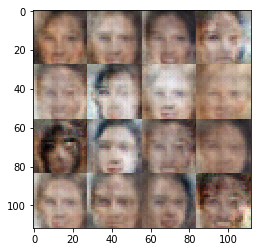

Epoch 1/1 Step 1430/1582: Discriminator Loss: 0.3942. Generator Loss: 2.4494
Epoch 1/1 Step 1435/1582: Discriminator Loss: 0.8463. Generator Loss: 3.6040
Epoch 1/1 Step 1440/1582: Discriminator Loss: 2.3540. Generator Loss: 3.0410
generator out (?, 28, 28, 3)


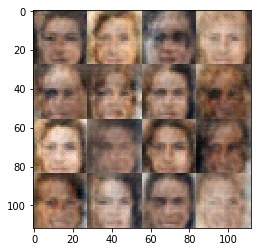

Epoch 1/1 Step 1445/1582: Discriminator Loss: 0.9254. Generator Loss: 0.9220
Epoch 1/1 Step 1450/1582: Discriminator Loss: 1.0475. Generator Loss: 1.1204
Epoch 1/1 Step 1455/1582: Discriminator Loss: 0.6178. Generator Loss: 1.5845
generator out (?, 28, 28, 3)


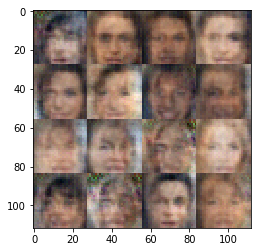

Epoch 1/1 Step 1460/1582: Discriminator Loss: 2.4538. Generator Loss: 0.1537
Epoch 1/1 Step 1465/1582: Discriminator Loss: 0.9021. Generator Loss: 0.8689
Epoch 1/1 Step 1470/1582: Discriminator Loss: 0.1195. Generator Loss: 4.0892
generator out (?, 28, 28, 3)


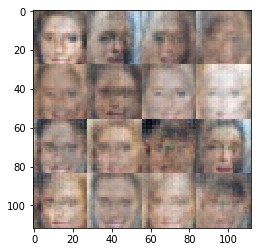

Epoch 1/1 Step 1475/1582: Discriminator Loss: 0.7678. Generator Loss: 0.9040
Epoch 1/1 Step 1480/1582: Discriminator Loss: 1.4682. Generator Loss: 4.0629
Epoch 1/1 Step 1485/1582: Discriminator Loss: 0.3557. Generator Loss: 3.3499
generator out (?, 28, 28, 3)


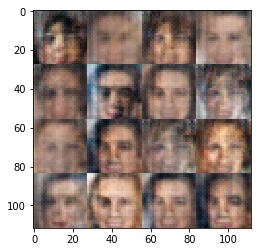

Epoch 1/1 Step 1490/1582: Discriminator Loss: 0.7876. Generator Loss: 0.9288
Epoch 1/1 Step 1495/1582: Discriminator Loss: 0.1889. Generator Loss: 2.5470
Epoch 1/1 Step 1500/1582: Discriminator Loss: 2.3291. Generator Loss: 6.7539
generator out (?, 28, 28, 3)


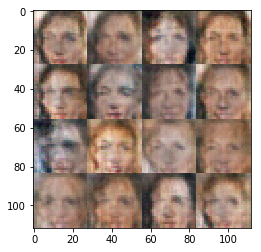

Epoch 1/1 Step 1505/1582: Discriminator Loss: 0.6418. Generator Loss: 3.1522
Epoch 1/1 Step 1510/1582: Discriminator Loss: 0.1826. Generator Loss: 3.6033
Epoch 1/1 Step 1515/1582: Discriminator Loss: 0.9759. Generator Loss: 3.7496
generator out (?, 28, 28, 3)


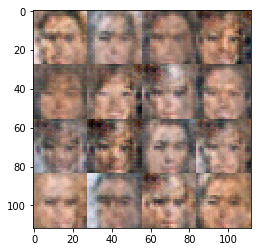

Epoch 1/1 Step 1520/1582: Discriminator Loss: 0.8879. Generator Loss: 0.9381
Epoch 1/1 Step 1525/1582: Discriminator Loss: 0.8503. Generator Loss: 6.3032
Epoch 1/1 Step 1530/1582: Discriminator Loss: 0.0849. Generator Loss: 4.6667
generator out (?, 28, 28, 3)


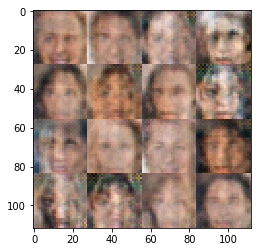

Epoch 1/1 Step 1535/1582: Discriminator Loss: 3.8111. Generator Loss: 6.9110
Epoch 1/1 Step 1540/1582: Discriminator Loss: 0.8940. Generator Loss: 0.7034
Epoch 1/1 Step 1545/1582: Discriminator Loss: 2.3493. Generator Loss: 4.0687
generator out (?, 28, 28, 3)


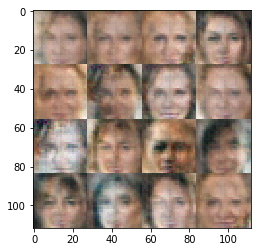

Epoch 1/1 Step 1550/1582: Discriminator Loss: 0.6270. Generator Loss: 3.5101
Epoch 1/1 Step 1555/1582: Discriminator Loss: 0.1928. Generator Loss: 2.5960
Epoch 1/1 Step 1560/1582: Discriminator Loss: 0.0889. Generator Loss: 4.8878
generator out (?, 28, 28, 3)


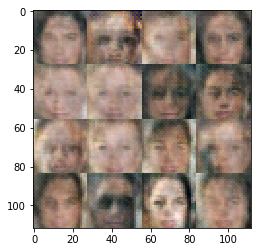

Epoch 1/1 Step 1565/1582: Discriminator Loss: 0.6513. Generator Loss: 1.0796
Epoch 1/1 Step 1570/1582: Discriminator Loss: 0.0981. Generator Loss: 4.1553
Epoch 1/1 Step 1575/1582: Discriminator Loss: 0.7086. Generator Loss: 1.0427
generator out (?, 28, 28, 3)


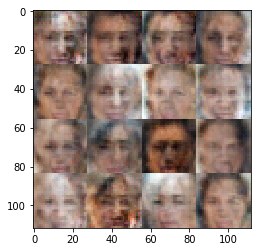

Epoch 1/1 Step 1580/1582: Discriminator Loss: 0.9900. Generator Loss: 0.6227


In [30]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.